<a href="https://colab.research.google.com/github/farbodtaymouri/BERT-GAN/blob/main/FinalProject6(Suffix_and_Remaining_time_Prediction_(NEW_GAME_(decoder_encoder)_Partition)_).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install strsim
!pip install XlsxWriter
#!pip install optuna

     |████████████████████████████████| 51kB 1.7MB/s 
     |████████████████████████████████| 153kB 2.8MB/s 


In [ ]:
from __future__ import print_function, division
import os
import sys
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import transforms, utils
import torch.nn as nn
from scipy.special import softmax
import torchvision
from torch.autograd import Variable
from sklearn.decomposition import PCA
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(linewidth=1000)
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init  as init
import pandas as pd
import random
import pprint
import copy
import random
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import precision_recall_fscore_support
from collections import defaultdict
import collections
from similarity.damerau import Damerau
import xlsxwriter
#import optuna
device=torch.device('cuda:0')
plt.style.use('ggplot')

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Tue Sep  8 03:07:07 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    24W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#Loading custom libraries
import sys
sys.path.append('/content/drive/My Drive/Deep Learing project')
#!pip install sru

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Reaging files from CSV
#dat = pd.read_csv('/Users/ftaymouri/Desktop/model temp/CSV/BPI2017.csv')
dat = pd.read_csv('/content/drive/My Drive/Deep Learing project/BPI2014.csv')
print("Types:", dat.dtypes)
#changing the data type from integer to category
dat['ActivityID'] = dat['ActivityID'].astype('category')
#dat['CompleteTimestamp'] = dat['CompleteTimestamp'].astype('datetime64[ns]')
dat['CompleteTimestamp'] = pd.to_datetime(dat['CompleteTimestamp'], dayfirst= True)
print("Types after:", dat.dtypes)

print("columns:", dat.columns)
dat_group=dat.groupby('CaseID')
print("Original data:", dat.head())
print("Group by data:", dat_group.head())

Types: CaseID                int64
ActivityID            int64
CompleteTimestamp    object
dtype: object
Types after: CaseID                        int64
ActivityID                 category
CompleteTimestamp    datetime64[ns]
dtype: object
columns: Index(['CaseID', 'ActivityID', 'CompleteTimestamp'], dtype='object')
Original data:    CaseID ActivityID   CompleteTimestamp
0       4         28 2013-01-07 08:17:00
1       4         21 2013-09-25 08:27:00
2       4         21 2013-11-04 12:09:00
3       4          3 2013-11-04 12:09:00
4       4         28 2013-11-04 12:09:00
Group by data:         CaseID ActivityID   CompleteTimestamp
0            4         28 2013-01-07 08:17:00
1            4         21 2013-09-25 08:27:00
2            4         21 2013-11-04 12:09:00
3            4          3 2013-11-04 12:09:00
4            4         28 2013-11-04 12:09:00
...        ...        ...                 ...
466732   47056          6 2014-03-31 15:42:00
466733   47057         20 2014-03-31 1

In [ ]:
#Data Preparation
#Iterating over groups in Pandas dataframe
data_augment=pd.DataFrame()
dat_group=dat.groupby('CaseID')
for name, gr in dat_group:
  #sorting by time
  gr = gr.sort_values(['CompleteTimestamp'])
  #print (gr)

  # dat[dat['CaseID'] == name] = dat[dat['CaseID'] == name].sort_values("CompleteTimestamp")
  # gr = dat[dat['CaseID'] == name]
  #computing the duration time in seconds by differecning x[t+1]-x[t]
  #duration_time = gr.loc[:,'CompleteTimestamp'].diff()/np.timedelta64(1,'s')
  duration_time = gr.loc[:,'CompleteTimestamp'].diff()/np.timedelta64(1,'D')
  #Filling Nan with 0
  duration_time.iloc[0] =0
  #print ("duration time:\n", duration_time)

  #computing the remaining time
  length=duration_time.shape[0]
  remaining_time = [np.sum(duration_time[i+1:length]) for i in range(duration_time.shape[0])]
  #print("Time to finish:\n", remaining_time)

  gr['duration_time'] = duration_time
  gr['remaining_time'] = remaining_time


  data_augment = data_augment.append(gr)

  #print("gr after:\n", gr)
  
  #break

In [ ]:
import pickle
# print(data_augment.shape)
# #Levels of Activity iDs
# data_augment['ActivityID'].cat.categories 
#pickle.dump( data_augment, open( "/Users/ftaymouri/Desktop/model temp/CSV/BPI2014.pkl", "wb" ) )
#pickle.dump( data_augment, open( "/content/drive/My Drive/Deep Learing project/BPI2014.pkl", "wb" ) )


In [ ]:
#data_augment = pickle.load( open( "/content/drive/My Drive/Deep Learing project/helpdesk(day).pkl", "rb" ) )
data_augment = pickle.load( open( "/content/drive/My Drive/Deep Learing project/BPI2012.pkl", "rb" ) )
#data_augment = pickle.load( open( "/Users/ftaymouri/Desktop/model temp/CSV/helpdesk.pkl", "rb" ) )

print(data_augment.shape)
print(data_augment.head(50))

(164506, 5)
    CaseID ActivityID       CompleteTimestamp  duration_time  remaining_time
0   173688         10 2011-10-01 08:38:44.546   0.000000e+00       12.457552
1   173688          7 2011-10-01 08:38:44.880   3.865741e-06       12.457548
2   173688          8 2011-10-01 08:39:37.906   6.137269e-04       12.456934
3   173688          1 2011-10-01 19:42:43.308   4.604792e-01       11.996455
4   173688         15 2011-10-01 19:45:09.243   1.689063e-03       11.994766
5   173688          6 2011-10-01 19:45:09.243   0.000000e+00       11.994766
6   173688         13 2011-10-01 19:45:11.197   2.261574e-05       11.994743
7   173688         16 2011-10-01 19:45:11.380   2.118056e-06       11.994741
8   173688         20 2011-10-01 19:45:13.917   2.936343e-05       11.994712
9   173688         22 2011-10-01 20:17:08.924   2.216443e-02       11.972547
10  173688         22 2011-10-09 01:32:00.886   7.218657e+00        4.753891
11  173688         17 2011-10-10 20:33:03.668   1.792393e+00    

In [ ]:
#Computing theaverage frequency of each activity per trace
activity_freq = dict.fromkeys(data_augment['ActivityID'].unique())

group= data_augment.groupby(['CaseID'])

trace_number=0
for n,g in group:
  trace_number+=1
  #print(g)
  freq = collections.Counter( g['ActivityID'] )
  for k in freq.keys():
    if (k in activity_freq):
      if(activity_freq[k]== None):
        activity_freq[k] = [freq[k]]
      else:
        activity_freq[k].append(freq[k])

for k in activity_freq:
  activity_freq[k] = [np.round(np.mean(activity_freq[k]),4), np.round(np.std(activity_freq[k]),4)]   

print(activity_freq)
print("Number of traces:",trace_number)




{10: [1.0, 0.0], 7: [1.0, 0.0], 8: [1.0, 0.0], 1: [1.0, 0.0], 15: [1.4018, 0.7524], 6: [1.0, 0.0], 13: [1.4018, 0.7524], 16: [1.4018, 0.7524], 20: [3.2533, 3.5301], 22: [4.5851, 3.6858], 17: [1.0615, 0.244], 9: [1.0, 0.0], 3: [1.0, 0.0], 11: [1.0, 0.0], 2: [1.0, 0.0], 23: [2.4603, 1.9324], 12: [1.3741, 0.7105], 5: [1.0, 0.0], 4: [1.0, 0.0], 18: [1.2404, 0.7283], 14: [1.0, 0.0], 21: [6.9259, 7.0263], 19: [2.5, 1.6073]}
Number of traces: 13087


In [ ]:
#Creating a desing matrix (one hot vectors for activities), End of line (case) is denoted by class 0
unique_event = sorted(data_augment['ActivityID'].unique())
print("uniqe events:", unique_event)

l=[]
for index, row in tqdm (data_augment.iterrows()):
  temp=dict()
  '''
  temp ={1: 0,
        2: 0,
        3: 1,
        4: 0,
        5: 0,
        6: 0,
        '0':0,
        'duration_time': 0.0,
        'remaining_time': 1032744.0}
  '''

  #Defning the columns we consider
  keys = ['0'] + list(unique_event) + ['duration_time','remaining_time']
  for k in keys:
    if(k == row['ActivityID']):
      temp[k]=1
    else:
      temp[k]=0

  temp['class'] = row['ActivityID']
  temp['duration_time'] = row['duration_time']
  temp['remaining_time'] = row['remaining_time']
  temp['CaseID'] = row['CaseID']
  
  l.append(temp)
  
#Creating a dataframe for dictionary l
desing_matrix = pd.DataFrame(l)
print("\n",desing_matrix.head(8))

In [ ]:
data_backup = copy.deepcopy(desing_matrix)

In [ ]:
desing_matrix = data_backup

In [ ]:
#Normalizing the duration time
duration_time_min = desing_matrix['duration_time'].min()
duration_time_max = desing_matrix['duration_time'].max()
print("The maximum duration time is:", duration_time_max)
desing_matrix['duration_time'] = (desing_matrix['duration_time'] - duration_time_min)/(duration_time_max - duration_time_min)
print(desing_matrix.head(5))

The maximum duration time is: 30.92262011574074
   0  1  2  3  4  5  ...  22  23  duration_time  remaining_time  class  CaseID
0  0  0  0  0  0  0  ...   0   0   0.000000e+00       12.457552     10  173688
1  0  0  0  0  0  0  ...   0   0   1.250134e-07       12.457548      7  173688
2  0  0  0  0  0  0  ...   0   0   1.984718e-05       12.456934      8  173688
3  0  1  0  0  0  0  ...   0   0   1.489134e-02       11.996455      1  173688
4  0  0  0  0  0  0  ...   0   0   5.462223e-05       11.994766     15  173688

[5 rows x 28 columns]


In [ ]:
# group = desing_matrix.groupby(['CaseID'])
# no_instance = int(group.ngroups*.3)

# #Random sampleing of cases
# case_id =[]
# for n,g in group:
#   if(no_instance>0):  
#     if(np.random.randint(0,2)):
#       case_id.append(n)
#       no_instance -=1

# desing_matrix= desing_matrix.loc[(desing_matrix['CaseID'].isin(case_id))]

The avrage length of traces: 12.57018415221212
The std of length of traces: 11.34700112887968
The max of length of traces: 96
the maximum of duration time location: 1.0


(array([7.614e+03, 2.790e+03, 1.708e+03, 6.680e+02, 2.010e+02, 5.700e+01, 3.300e+01, 9.000e+00, 5.000e+00, 2.000e+00]),
 array([ 3. , 12.3, 21.6, 30.9, 40.2, 49.5, 58.8, 68.1, 77.4, 86.7, 96. ]),
 <a list of 10 Patch objects>)

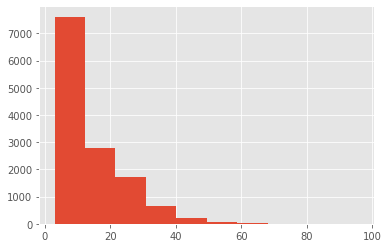

In [ ]:
group = desing_matrix.groupby('CaseID')

#Obtaning some statircis
trace_length_list = [gr.shape[0] for name, gr in group]
average_trace_length = np.mean(trace_length_list)
std_trace_length = np.std(trace_length_list)
max_trace_length = np.max(trace_length_list)
print("The avrage length of traces:", np.mean(trace_length_list))
print("The std of length of traces:", np.std(trace_length_list))
print("The max of length of traces:", np.max(trace_length_list))
print("the maximum of duration time location:", desing_matrix['duration_time'].max())
plt.hist(trace_length_list)

cases before filetring: 3804
cases after filetring: 3759
The avrage length of traces: 3.5365788773610003
The std of length of traces: 1.0076483787599593
The max of length of traces: 7
The min of length of traces: 1


(array([1.000e+00, 1.770e+02, 0.000e+00, 2.266e+03, 0.000e+00, 7.330e+02, 3.640e+02, 0.000e+00, 1.370e+02, 8.100e+01]),
 array([1. , 1.6, 2.2, 2.8, 3.4, 4. , 4.6, 5.2, 5.8, 6.4, 7. ]),
 <a list of 10 Patch objects>)

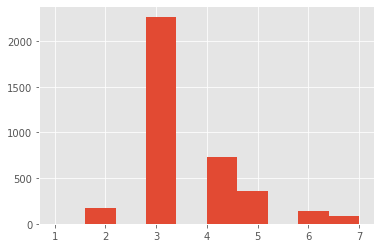

In [ ]:
# #Removing very long and very short traces
# print("cases before filetring:", desing_matrix.groupby(['CaseID']).ngroups)
# group= desing_matrix.groupby(['CaseID'])

# trace_length_list = [gr.shape[0] for name, gr in group]
# average_trace_length = np.mean(trace_length_list)
# std_trace_length = np.std(trace_length_list)
# max_trace_length = np.max(trace_length_list)

# case_id =[]
# for n,g in group:
#   #if (g.shape[0]< std_trace_length + average_trace_length  and g.shape[0]> average_trace_length - std_trace_length) :
#   #if (g.shape[0]> average_trace_length - 2*std_trace_length and g.shape[0]<  average_trace_length+ 2*std_trace_length ) :
#   if ( g.shape[0]<  average_trace_length+ 3*std_trace_length ) :
#   #if(g.shape[0]<=5 and g.shape[0]>=3):
    
#     case_id.append(n)


# desing_matrix= desing_matrix.loc[(desing_matrix['CaseID'].isin(case_id))]
# print("cases after filetring:", desing_matrix.groupby(['CaseID']).ngroups)


# group= desing_matrix.groupby(['CaseID'])
# trace_length_list = [gr.shape[0] for name, gr in group]
# # average_trace_length = np.mean(trace_length_list)
# # std_trace_length = np.std(trace_length_list)
# # max_trace_length = np.max(trace_length_list)
# print("The avrage length of traces:", np.mean(trace_length_list))
# print("The std of length of traces:", np.std(trace_length_list))
# print("The max of length of traces:", np.max(trace_length_list))
# print("The min of length of traces:", np.min(trace_length_list))
plt.hist(trace_length_list)

In [ ]:
def log_partition(desing_matrix, partition_width):
  '''
  Partitionaing the log such that traces with similar sizes are in the same partition
  desing_matrix: A pandas data frame
  partition_width: The difference between the longest and shortest trace in a partition
  output: A list of desing matrices 
  '''
  group= desing_matrix.groupby(['CaseID'])
  trace_length_list = [gr.shape[0] for name, gr in group]
  # average_trace_length = np.mean(trace_length_list)
  # std_trace_length = np.std(trace_length_list)
  max_trace_length = np.max(trace_length_list)
  min_trace_length = np.min(trace_length_list)

  no_partition = int(np.ceil( (max_trace_length - min_trace_length)/partition_width))
  print("The number of partitions:",no_partition)

  #temp=[]
  desing_matrix_partition_list=[]
  for i in range(no_partition):
    lower_ind = partition_width*i+min_trace_length 
    upper_ind = partition_width*(i+1)+min_trace_length


    case_id =[]
    for n,g in group:
      if (g.shape[0]>=lower_ind and g.shape[0]<  upper_ind ) :
        case_id.append(n)


    desing_matrix_partition_list.append(desing_matrix.loc[(desing_matrix['CaseID'].isin(case_id))])


  
    
  return desing_matrix_partition_list

desing_matrix_partition_list = log_partition(desing_matrix,2)


The number of partitions: 47


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


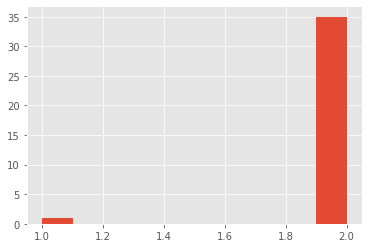

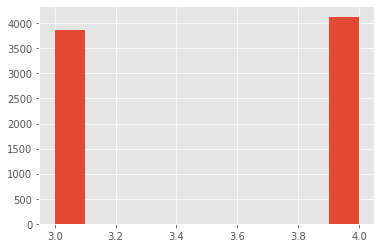

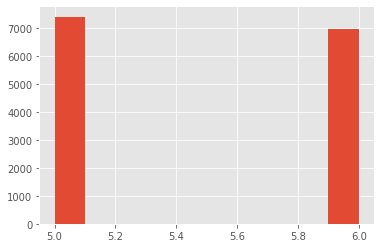

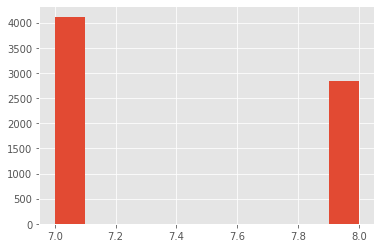

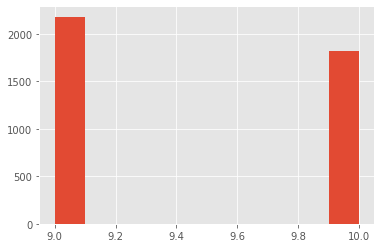

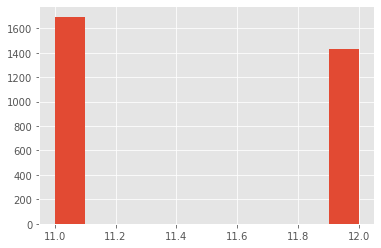

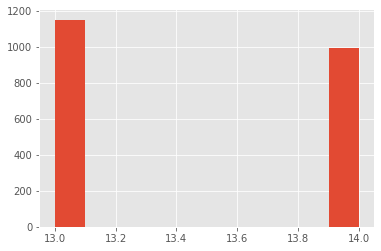

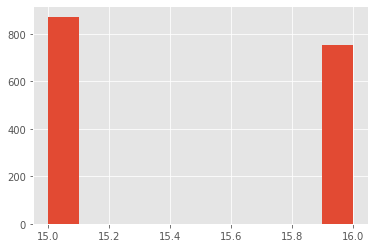

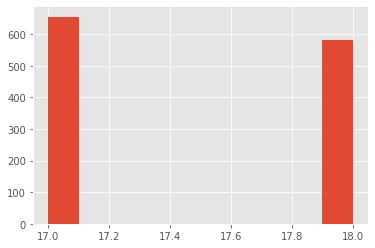

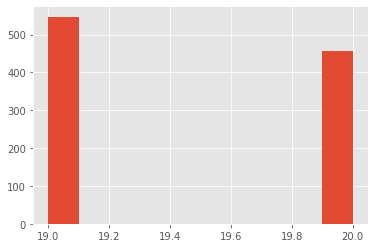

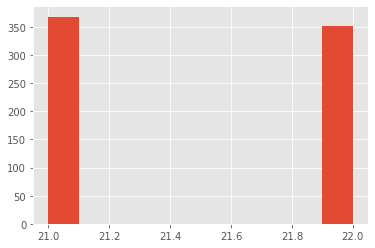

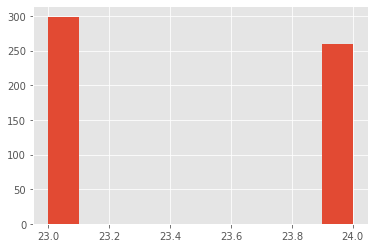

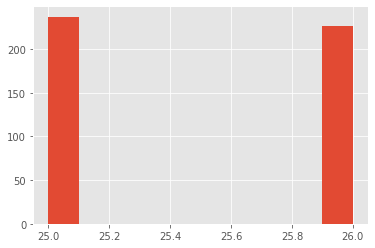

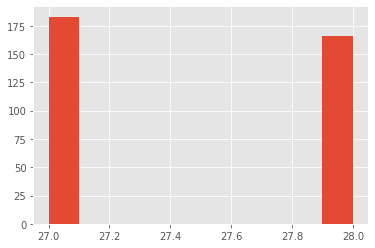

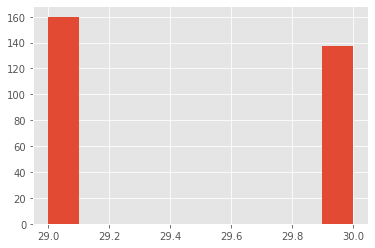

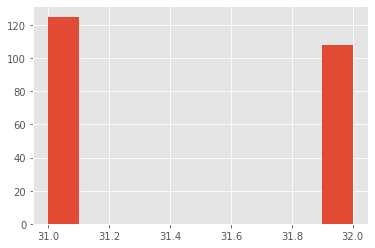

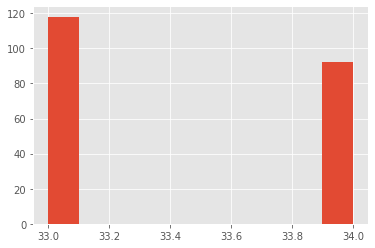

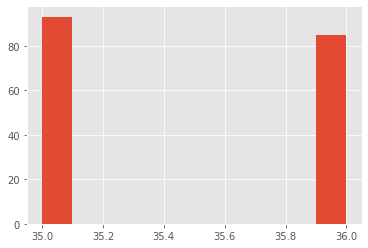

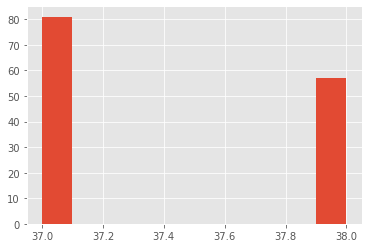

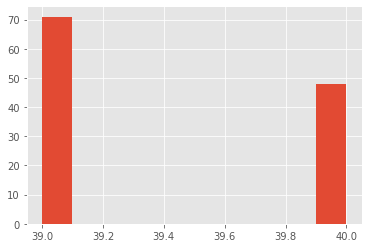

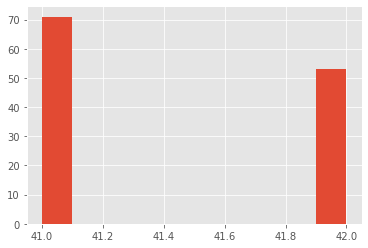

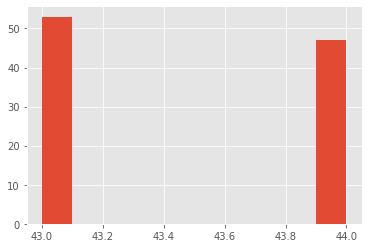

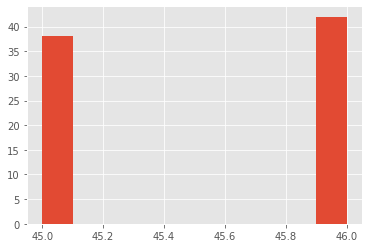

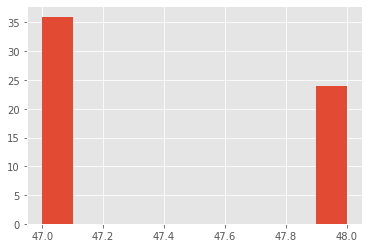

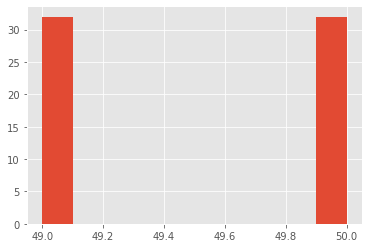

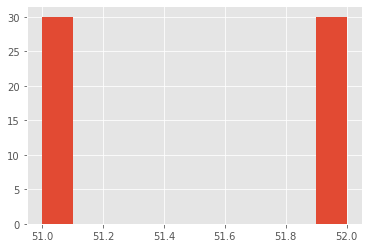

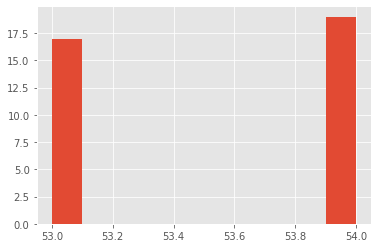

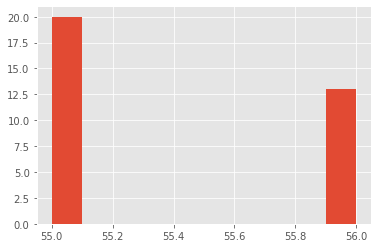

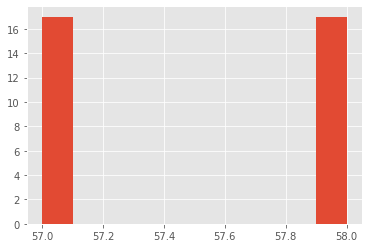

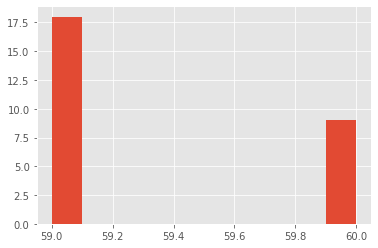

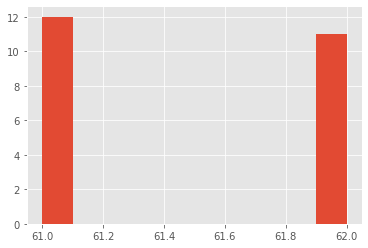

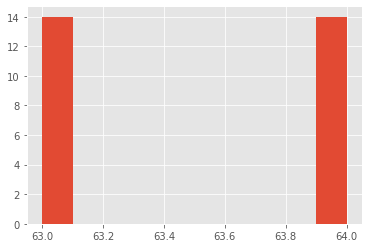

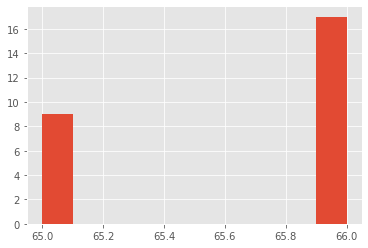

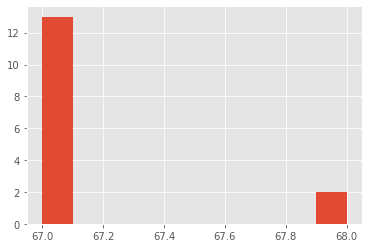

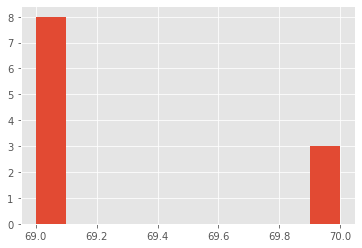

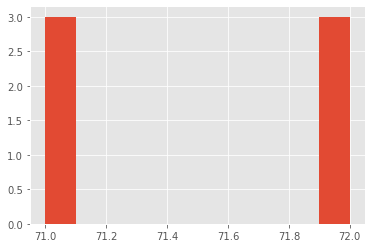

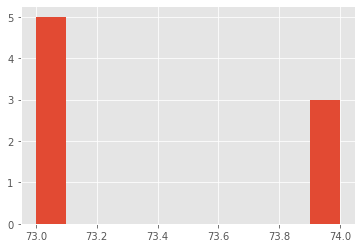

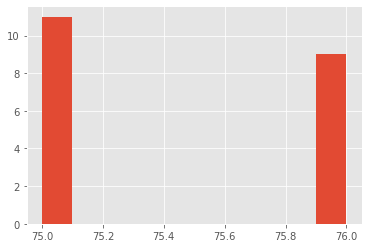

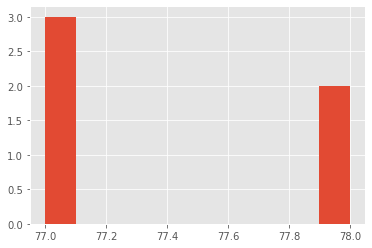

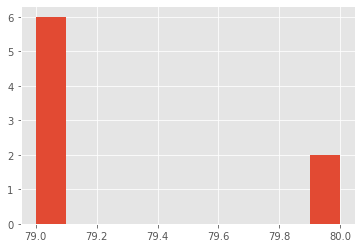

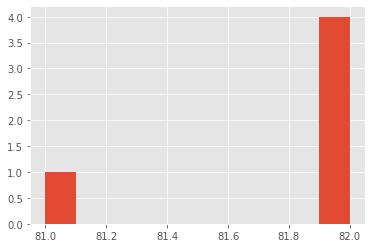

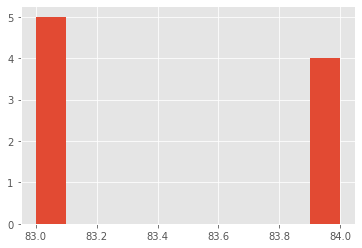

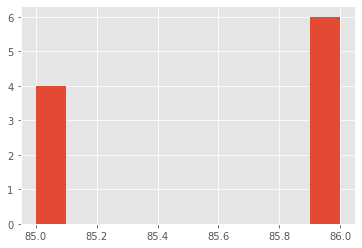

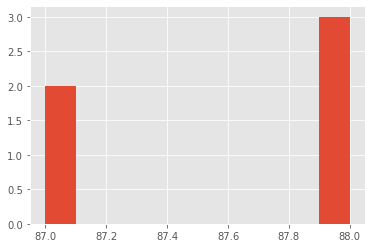

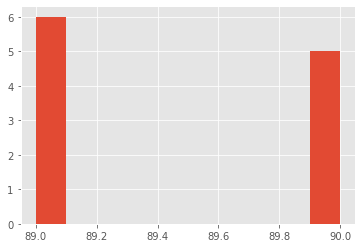

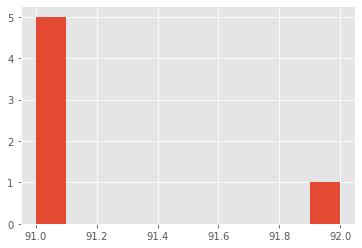

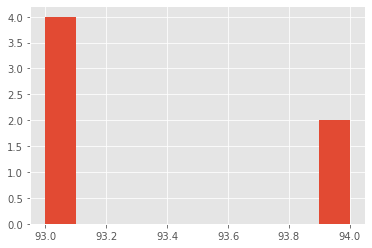

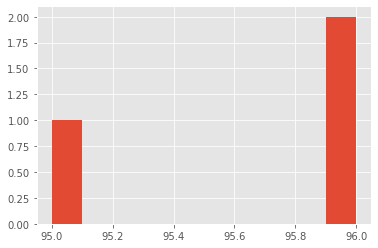

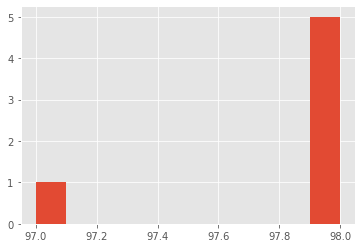

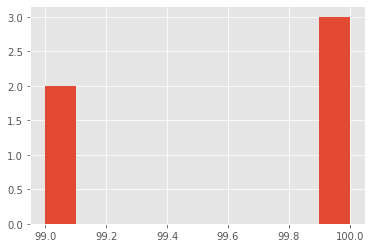

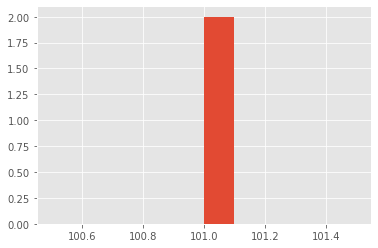

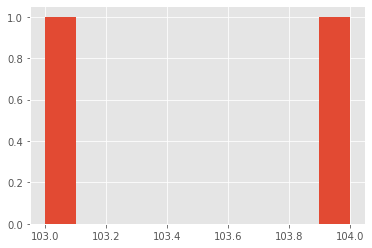

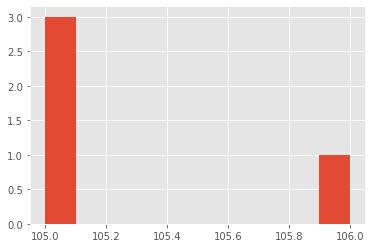

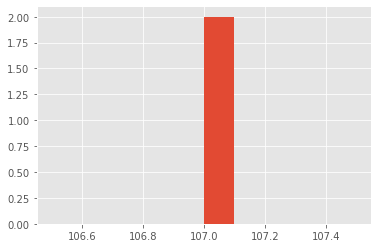

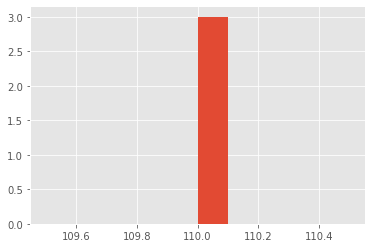

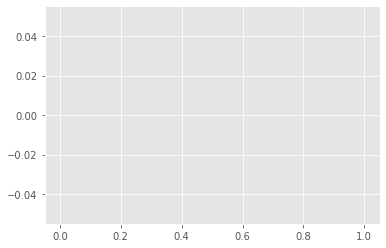

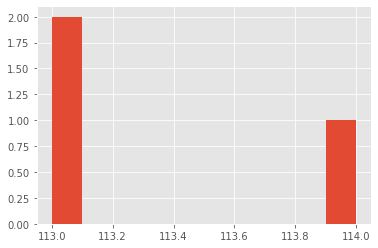

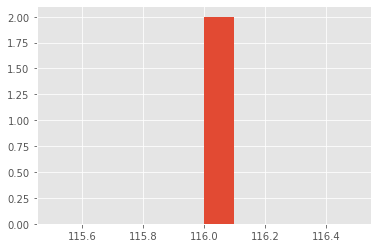

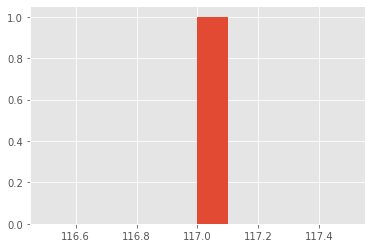

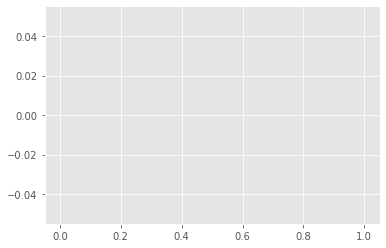

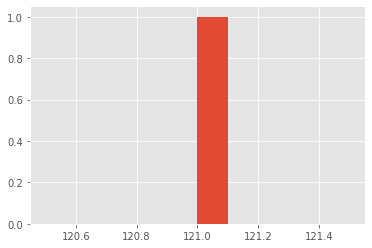

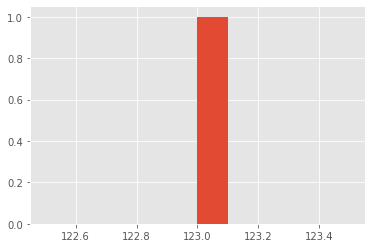

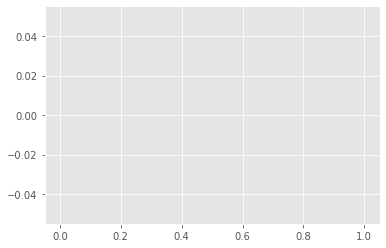

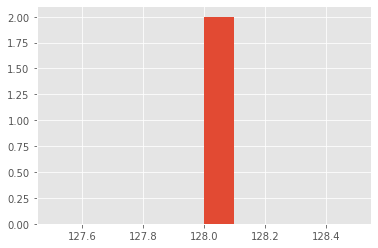

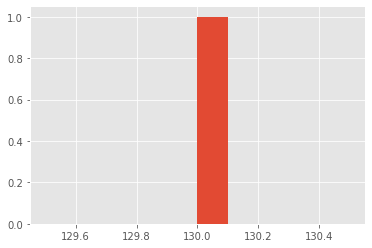

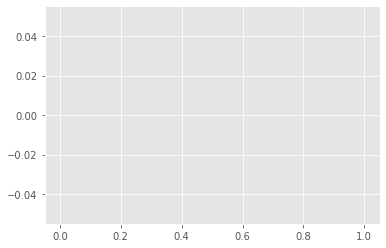

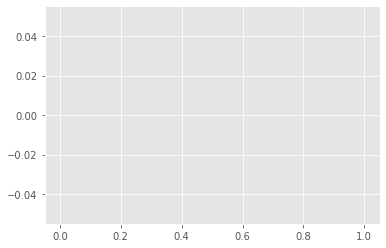

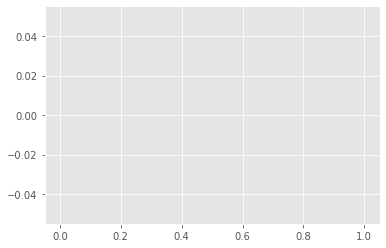

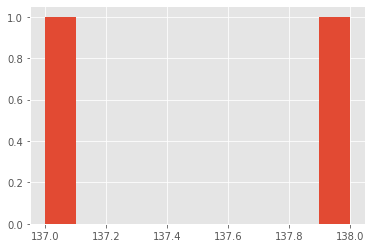

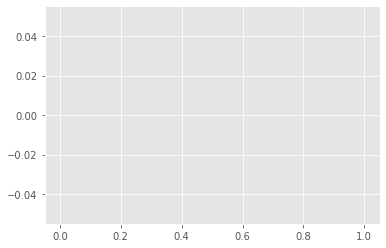

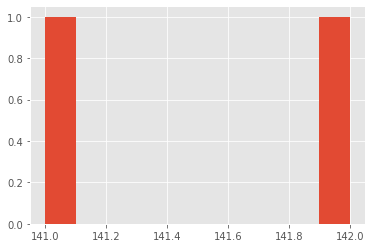

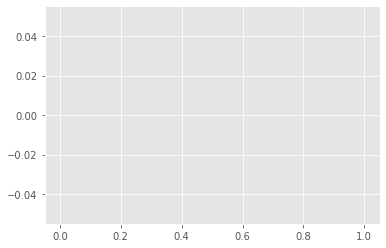

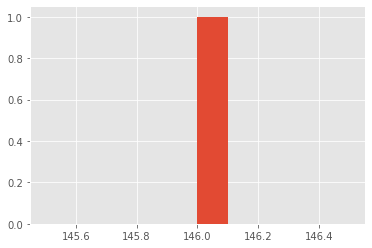

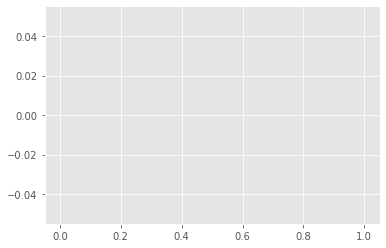

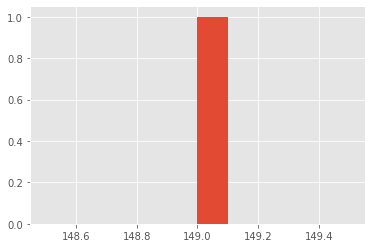

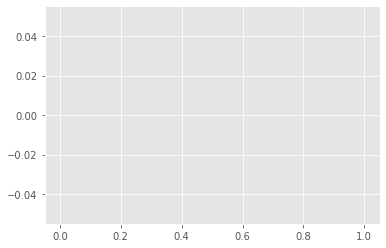

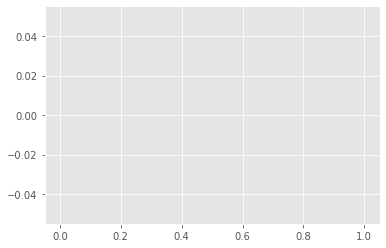

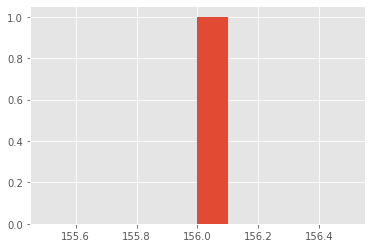

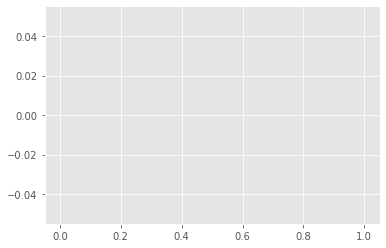

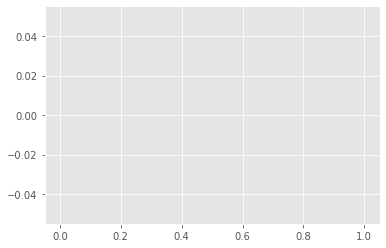

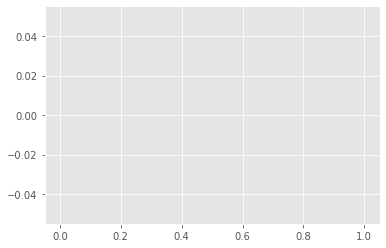

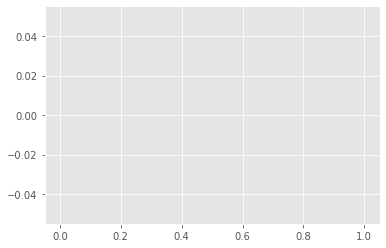

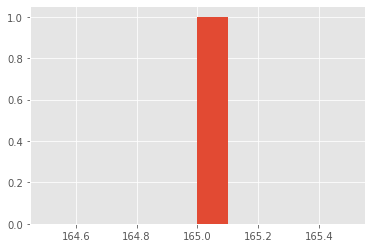

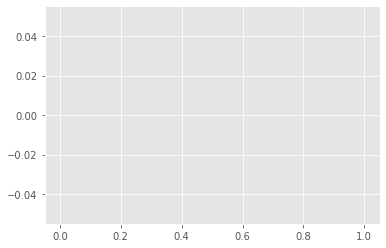

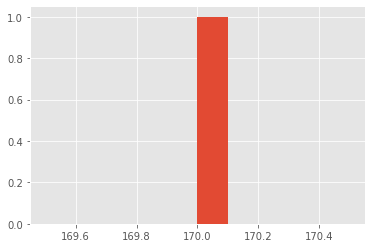

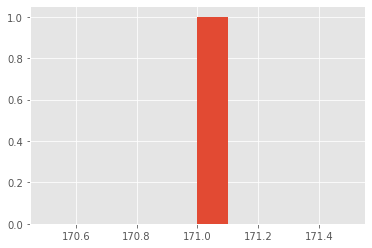

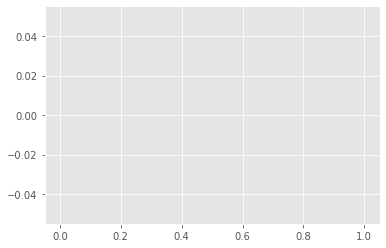

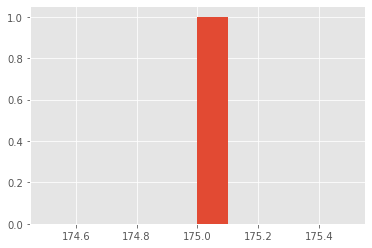

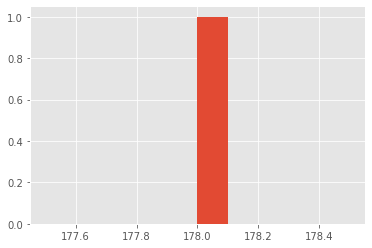

<Figure size 432x288 with 0 Axes>

In [ ]:
for dd in desing_matrix_partition_list:
  group= dd.groupby(['CaseID'])
  trace_length_list = [gr.shape[0] for name, gr in group]
  plt.hist(trace_length_list)
  plt.figure()

In [ ]:
#Selecting the desired columns
duration_time_loc= desing_matrix.columns.get_loc('duration_time')
selected_columns = [0]+unique_event+[duration_time_loc]
print(selected_columns)
desing_matrix.iloc[0:3,duration_time_loc]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]


0    0.000000e+00
1    1.250134e-07
2    1.984718e-05
Name: duration_time, dtype: float64

In [ ]:
def prefix_suffix_creating(desing_matrix_partition_list, prefix=2,  mode = "evemt_timestamp_prediction"):

    if(mode == "timestamp_prediction"):
      cls = [desing_matrix_partition_list[0].columns.get_loc('duration_time')]
    elif(mode == "event_prediction"):
      cls = [desing_matrix_partition_list[0].columns.get_loc('class')]
    elif(mode == 'event_timestamp_prediction'):
      cls = [desing_matrix_partition_list[0].columns.get_loc('duration_time')] + [desing_matrix.columns.get_loc('class')]
      

    prefix_from_begin_partition_list=[]
    suffix_to_end_partition_list=[]
    case_id_partition_list=[]

    for desing_matrix in desing_matrix_partition_list:
      #cls = desing_matrix.columns.get_loc('class')
      #cls = desing_matrix.columns.get_loc('duration_time')
      #cls = [desing_matrix.columns.get_loc('duration_time')] + [desing_matrix.columns.get_loc('class')]
      group = desing_matrix.groupby('CaseID')
     


      #Iterating over the groups to create tensors
      temp_prefix=[]
      temp_suffix=[]
      temp_case_id =[]
      for name, gr in group:
        


        
        #For each group, i.e., view, we create a new dataframe and reset the index
        gr = gr.copy(deep =True)
        gr = gr.reset_index(drop=True)
        
        #adding a new row at the bottom of each case to denote the end of a case
        new_row = [0]*gr.shape[1]
        gr.loc[gr.shape[0]] = new_row
        gr.iloc[gr.shape[0]-1,gr.columns.get_loc('0')] =1     #End of line is denoted by class 0

        gr_shift = gr.shift(periods=-1,fill_value=0)
        gr_shift.loc[gr.shape[0]-1,'0'] =1


        if(gr.shape[0] -1 > prefix):
          temp_case_id.append(name)
          # print(gr)
          # print("prefix:\n", gr.iloc[0:prefix])
          # print("suffix:\n", gr.iloc[prefix:])
          #case_id_list.append(gr['CaseID'][0])

          temp_prefix.append( torch.tensor(gr.iloc[0:prefix].values,dtype=torch.float, requires_grad=False).cuda())
          temp_suffix.append( torch.tensor(gr.iloc[prefix:].values,dtype=torch.float, requires_grad=False).cuda())

          # print("temp prefix:\n", temp_prefix[0][0])
          # print("temp suffix:\n", temp_suffix)
          # break



      #     for i in range(gr.shape[0]):
      #       # if (i+prefix == gr.shape[0]):
      #       #   break
      #       #print(gr.iloc[i:i+prefix])
      #       temp.append( torch.tensor(gr.iloc[i:i+prefix].values,dtype=torch.float, requires_grad=False).cuda())

      #       # #----------------
      #       # #print("the prediction:", "the i", i ,gr.iloc[i+prefix,cls])
      #       # temp_shifted.append(torch.tensor([gr.iloc[i+prefix,cls]],dtype=torch.float, requires_grad=False))
      #       # #print("------------------------------------------------------------")
      #       # #------------------

      #       #Storing the next element after the prefix as the prediction class
      #       try:
      #           #print("the prediction:", "the i", i ,gr.iloc[i+prefix,cls])
      #           temp_shifted.append(torch.tensor([gr.iloc[i+prefix,cls]],dtype=torch.float, requires_grad=False).cuda())

      #       except IndexError:
      #           #Printintg the end of sequence
      #           #print("the prediction:", "ESLE the i", i ,torch.tensor(np.zeros(len(cls))))
      #           temp_shifted.append(torch.tensor([np.float16(0)],dtype=torch.float, requires_grad=False).cuda())
      #           #temp_shifted.append(torch.tensor([0.0]*len(cls),dtype=torch.float, requires_grad=False))
      #       #print("****************************")

      #   #print(gr['class'][0], gr.iloc[0:3,:], gr.shape)
      #   #print("Temp:",temp, temp[0].size(), "shifted\n", temp_shifted)
      #     #print("-------------------------------------------------------------------------")

      try:
      #This part msakes easier to work afterward   
        temp_prefix= pad_sequence(temp_prefix, batch_first=True, padding_value=0)
        temp_suffix = pad_sequence(temp_suffix, batch_first=True, padding_value=0)

        prefix_from_begin_partition_list.append(temp_prefix)
        suffix_to_end_partition_list.append(temp_suffix)
        case_id_partition_list.append(temp_case_id)

      except IndexError:
        pass

      # temp_prefix= torch.nn.utils.rnn.pack_padded_sequence(temp_prefix, batch_first=True)
      # temp_suffix = torch.nn.utils.rnn.pack_padded_sequence(temp_suffix, batch_first=True)

    return prefix_from_begin_partition_list, suffix_to_end_partition_list, case_id_partition_list


prefix_len_for_suffix_generation = 14
prefix_from_begin_partition_list, suffix_to_end_partition_list, case_id_partition_list = prefix_suffix_creating( desing_matrix_partition_list, prefix=prefix_len_for_suffix_generation, mode="event_prediction")




In [ ]:
def prefix_suffix_variable_length_creating(desing_matrix_partition_list):
  '''
  selexting (prefix,suffix) of variable length
  '''
  prefix_suffix_dic = {}
  for i in range(2, int(max_trace_length)):
    print("prefix,suffix:",i)
    #Creating prefix and suffix of different length
    prefix_from_begin_partition_list, suffix_to_end_partition_list, case_id_partition_list = prefix_suffix_creating( desing_matrix_partition_list, prefix=i, mode="event_prediction")


    prefix_suffix_dic[i]=(prefix_from_begin_partition_list, suffix_to_end_partition_list, case_id_partition_list )

  pr_all=[]
  sf_all=[]
  id_all=[]
  for k in prefix_suffix_dic.keys():
    pr_all += prefix_suffix_dic[k][0]
    sf_all += prefix_suffix_dic[k][1]
    id_all += prefix_suffix_dic[k][2]

  return pr_all, sf_all, id_all
    
prefix_from_begin_partition_list, suffix_to_end_partition_list, case_id_partition_list = prefix_suffix_variable_length_creating(desing_matrix_partition_list)

prefix,suffix: 4
prefix,suffix: 5
prefix,suffix: 6
prefix,suffix: 7
prefix,suffix: 8
prefix,suffix: 9
prefix,suffix: 10
prefix,suffix: 11
prefix,suffix: 12
prefix,suffix: 13


In [ ]:
#pickle.dump( (prefix_from_begin_partition_list, suffix_to_end_partition_list,  case_id_partition_list), open( "/content/drive/My Drive/Deep Learing project/Prefix-suffix BPI14.pkl", "wb" ) )
uu= pickle.load( open( "/content/drive/My Drive/Deep Learing project/Prefix-suffix BPI12.pkl", "rb" ) )
prefix_from_begin_partition_list, suffix_to_end_partition_list, case_id_partition_list = uu[0],uu[1], uu[2]

In [ ]:
# prefix_from_begin_partition_list[6].size()
# temp1=[]
# temp2=[]
# for i in range(len(prefix_from_begin_partition_list)):
#   if(prefix_from_begin_partition_list[i].size()[1]>=5):
#     temp1.append(prefix_from_begin_partition_list[i])
#     temp2.append(suffix_to_end_partition_list[i])

# for i in range(len(temp1)):
#   print(temp1[i].size())

# prefix_from_begin_partition_list = temp1
# suffix_to_end_partition_list = temp2

In [ ]:
# #[185548]
# #torch.nn.utils.rnn.pack_padded_sequence(desing_matrix_padded, lengths, batch_first=True, enforce_sorted=True)
events = list(np.arange(0,len(unique_event)+1))
# suffix_to_end.size()
# suffix_to_end[1,:,events]
# l=[]
# for i in range(suffix_to_end.size()[0]):
#   k = suffix_to_end[i,:,events]
#   l.append(np.sum([1  for j in range(k.size()[0]) if k[j][0]!=-1]))

# pp = torch.nn.utils.rnn.pack_padded_sequence(suffix_to_end , lengths = torch.tensor(l), batch_first=True, enforce_sorted=False)
# suffix_to_end_partition_list[2][0,:,events]
# for dl in valid_suffix_loader_partition_list:
#     data_loader = dl
#     print(dl.dataset.tensors[0], dl.dataset.tensors[1])
#     print(dl.dataset.tensors[0].size(), dl.dataset.tensors[1].size())
#     print("RRRRRRRRRRRRRRRRRRRRRRRR:", dl.dataset[0][1].size())

# for i in range(len(prefix_from_begin_partition_list)):
#   print(prefix_from_begin_partition_list[i].size(), suffix_to_end_partition_list[i].size())

# prefix_from_begin_partition_list[8].size(), suffix_to_end_partition_list[8].size()

# tt = TensorDataset(prefix_from_begin_partition_list[8],suffix_to_end_partition_list[8])
# tt.tensors[0].size()
# tv = DataLoader(dataset=tt, batch_size=4, shuffle=False)
# tv.dataset.tensors[0].size()

In [ ]:
# print(suffix_to_end.size())
# # # s1 = suffix_to_end
# # # p1 = prefix_from_begin

# # s2 = suffix_to_end
# # p2 = prefix_from_begin
# pp.data.size()
# pp.batch_sizes


In [ ]:
print(len(prefix_from_begin))
print(desing_matrix.groupby("CaseID").ngroups)
prefix_from_begin[0][:,2:5]

1183
1786


tensor([[0., 1., 0.],
        [0., 0., 0.],
        [0., 0., 0.]], device='cuda:0')

In [ ]:
# #Creating the desing matrix based on given prefix. 
# def Prefix_creating(prefix=2, mode = "event_timestamp_prediction"):
      
#     #   prefix=3
#     #   0  1  2  3  4  5  6  duration_time  remaining_time  class  CaseID
#     # 0  0  0  0  1  0  0  0            0.0       1032744.0      3  173688
#     # 1  0  0  0  0  0  1  0         1915.0       1030829.0      5  173688
#     # 2  0  0  0  0  0  1  0       620092.0        410737.0      5  173688
#     # ---------------------
#     # the prediction: 5
#     #   0  1  2  3  4  5  6  duration_time  remaining_time  class  CaseID
#     # 1  0  0  0  0  0  1  0         1915.0       1030829.0      5  173688
#     # 2  0  0  0  0  0  1  0       620092.0        410737.0      5  173688
#     # 3  0  0  0  0  0  1  0       154865.0        255872.0      5  173688
#     # ---------------------
#     # the prediction: 6
#     #   0  1  2  3  4  5  6  duration_time  remaining_time  class  CaseID
#     # 2  0  0  0  0  0  1  0       620092.0        410737.0      5  173688
#     # 3  0  0  0  0  0  1  0       154865.0        255872.0      5  173688
#     # 4  0  0  0  0  0  0  1       255872.0             0.0      6  173688
#     # ---------------------
#     # the prediction: 0
#     #   0  1  2  3  4  5  6  duration_time  remaining_time  class  CaseID
#     # 3  0  0  0  0  0  1  0       154865.0        255872.0      5  173688
#     # 4  0  0  0  0  0  0  1       255872.0             0.0      6  173688
#     # 5  1  0  0  0  0  0  0            0.0             0.0      0       0

#     if(mode == "timestamp_prediction"):
#       cls = [desing_matrix.columns.get_loc('duration_time')]
#     elif(mode == "event_prediction"):
#       cls = [desing_matrix.columns.get_loc('class')]
#     elif(mode == 'event_timestamp_prediction'):
#       cls = [desing_matrix.columns.get_loc('duration_time')] + [desing_matrix.columns.get_loc('class')]
      



#     #cls = desing_matrix.columns.get_loc('class')
#     #cls = desing_matrix.columns.get_loc('duration_time')
#     #cls = [desing_matrix.columns.get_loc('duration_time')] + [desing_matrix.columns.get_loc('class')]
#     group = desing_matrix.groupby('CaseID')

#     #Iterating over the groups to create tensors
#     temp=[]
#     temp_shifted=[]
#     for name, gr in group:
      
#       #For each group, i.e., view, we create a new dataframe and reset the index
#       gr = gr.copy(deep =True)
#       gr = gr.reset_index(drop=True)
      
#       #adding a new row at the bottom of each case to denote the end of a case
#       new_row = [0]*gr.shape[1]
#       gr.loc[gr.shape[0]] = new_row
#       gr.iloc[gr.shape[0]-1,gr.columns.get_loc('0')] =1     #End of line is denoted by class 0

#       gr_shift = gr.shift(periods=-1,fill_value=0)
#       gr_shift.loc[gr.shape[0]-1,'0'] =1



#       #Selecting only traces that has length greater than the defined prefix
#       #cls = gr.columns.get_loc('class')
#       if(gr.shape[0] -1 > prefix):
#         for i in range(gr.shape[0]):
#           # if (i+prefix == gr.shape[0]):
#           #   break
#           #print(gr.iloc[i:i+prefix])
#           temp.append( torch.tensor(gr.iloc[i:i+prefix].values,dtype=torch.float, requires_grad=False).cuda())

#           # #----------------
#           # #print("the prediction:", "the i", i ,gr.iloc[i+prefix,cls])
#           # temp_shifted.append(torch.tensor([gr.iloc[i+prefix,cls]],dtype=torch.float, requires_grad=False))
#           # #print("------------------------------------------------------------")
#           # #------------------

#           #Storing the next element after the prefix as the prediction class
#           try:
#               #print("the prediction:", "the i", i ,gr.iloc[i+prefix,cls])
#               temp_shifted.append(torch.tensor([gr.iloc[i+prefix,cls]],dtype=torch.float, requires_grad=False).cuda())

#           except IndexError:
#               #Printintg the end of sequence
#               #print("the prediction:", "ESLE the i", i ,torch.tensor(np.zeros(len(cls))))
#               temp_shifted.append(torch.tensor([np.float16(0)],dtype=torch.float, requires_grad=False).cuda())
#               #temp_shifted.append(torch.tensor([0.0]*len(cls),dtype=torch.float, requires_grad=False))
#           #print("****************************")

#       #print(gr['class'][0], gr.iloc[0:3,:], gr.shape)
#       #print("Temp:",temp, temp[0].size(), "shifted\n", temp_shifted)
#         #print("-------------------------------------------------------------------------")


        
#     desing_matrix_padded = pad_sequence(temp, batch_first=True)
#     desing_matrix_shifted_padded = pad_sequence(temp_shifted, batch_first=True)

#     return desing_matrix_padded, desing_matrix_shifted_padded



# #Calling the function to have the dataset
# prefix_len = 21
# desing_matrix_padded , y = Prefix_creating(prefix_len, mode="event_timestamp_prediction")
# #desing_matrix_padded , y2 = Prefix_creating(prefix_len, mode="timestamp_prediction")

In [ ]:
def Pad_correction(suffix_to_end_partition_list):
  #The first column is the stop word (end of sequence) showing by class number zero, however
  #When padding it does not marke it, so we have to set it as 1, otherwise the model being trained coudn't understant where to stop
  # tensor([[0., 0., 0., 1., 0., 0., 0.],
  #       [0., 0., 0., 0., 0., 1., 0.],
  #       [0., 0., 0., 0., 0., 1., 0.],
  #       [0., 0., 0., 0., 0., 1., 0.]])
  # #------------------------------------
  # tensor([[0., 0., 0., 0., 0., 1., 0.],
  #       [0., 0., 0., 0., 0., 1., 0.],
  #       [0., 0., 0., 0., 0., 1., 0.],
  #       [0., 0., 0., 0., 0., 0., 1.]])
  # #------------------------------------
  # tensor([[0., 0., 0., 0., 0., 1., 0.],
  #       [0., 0., 0., 0., 0., 1., 0.],
  #       [0., 0., 0., 0., 0., 0., 1.],
  #       [1., 0., 0., 0., 0., 0., 0.]])
  # #------------------------------------
  # tensor([[0., 0., 0., 0., 0., 1., 0.],
  #       [0., 0., 0., 0., 0., 0., 1.],
  #       [1., 0., 0., 0., 0., 0., 0.],
  #       [1., 0., 0., 0., 0., 0., 0.]])
  # #------------------------------------
  # tensor([[0., 0., 0., 0., 0., 0., 1.],
  #       [1., 0., 0., 0., 0., 0., 0.],
  #       [1., 0., 0., 0., 0., 0., 0.],
  #       [1., 0., 0., 0., 0., 0., 0.]])

  for j in range(len(suffix_to_end_partition_list)):
    for i in range(suffix_to_end_partition_list[j].size()[0]):
      u=(suffix_to_end_partition_list[j][i,:,0] == 1).nonzero()

      try:
        suffix_to_end_partition_list[j][i,:,0][u:] = 1
      except TypeError:
        pass


#Pad_correction(desing_matrix_padded)
Pad_correction(suffix_to_end_partition_list)

In [ ]:
suffix_to_end_partition_list[0][:,:,events]

tensor([[[0., 0., 0.,  ..., 0., 1., 0.],
         [0., 0., 0.,  ..., 0., 0., 1.],
         [0., 0., 0.,  ..., 0., 0., 1.],
         [0., 0., 0.,  ..., 0., 0., 1.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 1.],
         [0., 0., 0.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 1., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0

In [ ]:
print("the class variable:",y[0:4])
print(desing_matrix_padded.size())
#print((desing_matrix_padded[4,:,0] == 1).nonzero())
u =(desing_matrix_padded[4,:,0] == 1).nonzero()
#desing_matrix_padded[0:3,:,[0]+unique_event]
desing_matrix_padded[0:3,:,selected_columns]
suffix_to_end[:,:,events]

the class variable: tensor([[[3.0400e-03, 5.0000e+00]],

        [[1.7955e-02, 5.0000e+00]],

        [[0.0000e+00, 0.0000e+00]],

        [[0.0000e+00, 0.0000e+00]]], device='cuda:0')
torch.Size([2839, 20, 11])


tensor([[[0., 0., 0.,  ..., 0., 1., 0.],
         [0., 0., 0.,  ..., 0., 0., 1.],
         [1., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 1., 0.],
         [0., 0., 0.,  ..., 0., 1., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 1.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 1., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0')

In [ ]:
print("The dimension of desinged matrix:", desing_matrix_padded.size())
print("The dim of ground truth:", y.size())
print("The prefix considred so far:", desing_matrix_padded.size()[1])

In [ ]:
# #Creating Validation and Test sets
# #Generating index for training datset
# #train_inds = random.sample(range(desing_matrix_padded.size()[0]), k = round(desing_matrix_padded.size()[0]*.8))
# #train_inds = np.random.randint(low=0, high = desing_matrix_padded.size()[0], size = round(desing_matrix_padded.size()[0]*.9))
# train_inds = np.arange(0, round(desing_matrix_padded.size()[0]*.8))

# #Generating index for the test dataset
# test_inds = list( set(range(desing_matrix_padded.size()[0])).difference(set(train_inds))  )
# validation_inds = test_inds[0:round(0.3*len(test_inds))]
# test_inds = test_inds[round(0.1*len(test_inds)): ]


# print(len(train_inds))
# print(len(test_inds))
# print(len(validation_inds))

2271
511
170


In [ ]:
# batch = 4
# train_data = TensorDataset(desing_matrix_padded[train_inds],y[train_inds])
# #Creating the batchsize
# train_loader = DataLoader(dataset=train_data, batch_size=batch, shuffle=False)
# #Retriving miniBatch data
# a=next(iter(train_loader))
# # print(a[0].size())
# # print(a[0][:,:,selected_columns])



# test_data = TensorDataset(desing_matrix_padded[test_inds],y[test_inds])
# #Creating the batchsize
# test_loader = DataLoader(dataset=test_data, batch_size=batch, shuffle=False)


# validation_data = TensorDataset(desing_matrix_padded[validation_inds],y[validation_inds])
# #Creating the batchsize
# validation_loader = DataLoader(dataset=validation_data, batch_size=batch, shuffle=False)




In [ ]:
# batch = 4
# ##########################################################################################
# #Creating batches for the ground truth prefixes and suffixes
# #Creating prefix_from_begin and corresponding suffixes
# train_inds_suffix = np.arange(0, round(prefix_from_begin.size()[0]*.8))
# test_inds_suffix = list( set(range(prefix_from_begin.size()[0])).difference(set(train_inds_suffix))  )
# validation_inds_suffix = test_inds_suffix[0:round(0.3*len(test_inds_suffix))]
# test_inds_suffix = test_inds_suffix[round(0.1*len(test_inds_suffix)): ]



# train_suffix_data = TensorDataset(prefix_from_begin[train_inds_suffix],suffix_to_end[train_inds_suffix])
# train_suffix_loader = DataLoader(dataset=train_suffix_data, batch_size=batch, shuffle=False)

# test_suffix_data = TensorDataset(prefix_from_begin[test_inds_suffix],suffix_to_end[test_inds_suffix])
# test_suffix_loader = DataLoader(dataset=test_suffix_data, batch_size=batch, shuffle=False)

# validation_suffix_data = TensorDataset(prefix_from_begin[validation_inds_suffix],suffix_to_end[validation_inds_suffix])
# validation_suffix_loader = DataLoader(dataset=validation_suffix_data, batch_size=batch, shuffle=False)

# ####################################################################
# ##################################################################

In [ ]:
def train_valid_test_loader(prefix_from_begin_partition_list, suffix_to_end_partition_list, case_id_partition_list ,batch=4):
  '''
  Creating train,test, and validation loaders
  '''
  train_suffix_loader_partition_list=[]
  test_suffix_loader_partition_list=[]
  valid_suffix_loader_partition_list=[]

  #Iterating over the list of prefixes and suffixes
  for i in range(len(prefix_from_begin_partition_list)):
    prefix_from_begin = prefix_from_begin_partition_list[i]
    suffix_to_end = suffix_to_end_partition_list[i]
    case_id = torch.tensor(case_id_partition_list[i])

    # train_inds_suffix = np.arange(0, round(prefix_from_begin.size()[0]*.8))
    # test_inds_suffix = list( set(range(prefix_from_begin.size()[0])).difference(set(train_inds_suffix))  )
    # validation_inds_suffix = test_inds_suffix[0:round(0.3*len(test_inds_suffix))]
    # test_inds_suffix = test_inds_suffix[round(0.1*len(test_inds_suffix)): ]

    #if(prefix_from_begin.size()[0]>30):
    train_inds_suffix = np.arange(0, round(prefix_from_begin.size()[0]*.7))
    validation_inds_suffix = np.arange(round(prefix_from_begin.size()[0]*.7), round(prefix_from_begin.size()[0]*.8))
    test_inds_suffix = np.arange(round(prefix_from_begin.size()[0]*.8), round(prefix_from_begin.size()[0]))
    #print("prefix:",i, len(train_inds_suffix),len(validation_inds_suffix),len(test_inds_suffix), prefix_from_begin.size()[1] + suffix_to_end.size()[1]  )
    # else:
    #   train_inds_suffix = np.arange(0, round(prefix_from_begin.size()[0]))
    #   validation_inds_suffix = []
    #   test_inds_suffix = []

    

    #Temporary
    #test_inds_suffix = np.array(list(train_inds_suffix)+list(validation_inds_suffix)+list(test_inds_suffix))



    #In a rare cases when the number of traning is less than 5
    if( len(test_inds_suffix)==0 or len(validation_inds_suffix)==0 ):
      test_inds_suffix = train_inds_suffix
      validation_inds_suffix = train_inds_suffix
      #continue

    # print("The number of train, test, validation instances in each partition:")
    # print(len(train_inds_suffix), len(test_inds_suffix), len(validation_inds_suffix))


    train_suffix_data = TensorDataset(prefix_from_begin[train_inds_suffix],suffix_to_end[train_inds_suffix], case_id[train_inds_suffix])
    train_suffix_loader = DataLoader(dataset=train_suffix_data, batch_size=batch, shuffle=False)

    test_suffix_data = TensorDataset(prefix_from_begin[test_inds_suffix],suffix_to_end[test_inds_suffix], case_id[test_inds_suffix])
    test_suffix_loader = DataLoader(dataset=test_suffix_data, batch_size=batch, shuffle=False)

    validation_suffix_data = TensorDataset(prefix_from_begin[validation_inds_suffix],suffix_to_end[validation_inds_suffix], case_id[validation_inds_suffix])
    validation_suffix_loader = DataLoader(dataset=validation_suffix_data, batch_size=batch, shuffle=False)

    train_suffix_loader_partition_list.append(train_suffix_loader)
    test_suffix_loader_partition_list.append(test_suffix_loader)
    valid_suffix_loader_partition_list.append(validation_suffix_loader)


  return train_suffix_loader_partition_list, test_suffix_loader_partition_list, valid_suffix_loader_partition_list

batch =128
train_suffix_loader_partition_list, test_suffix_loader_partition_list, valid_suffix_loader_partition_list = train_valid_test_loader(prefix_from_begin_partition_list[:], suffix_to_end_partition_list[:], case_id_partition_list[:], batch =batch)

In [ ]:
# prefix_from_begin.size()
# suffix_to_end.size()
# prefix_from_begin[validation_inds_suffix].size()
# prefix_from_begin[test_inds_suffix].size()
train_suffix_loader_partition_list[0].dataset.tensors[1].size()

torch.Size([2399, 3, 14])

In [ ]:
# #Just for testing (for BPI2012 and big models)-temporary
# train_inds = train_inds[0:int(len(train_inds)*.1)]
# test_inds = test_inds[0:int(len(test_inds)*.1)]
# validation_inds = validation_inds[0:int(len(validation_inds)*.1)]

# print(len(train_inds))
# print(len(test_inds))
# print(len(validation_inds))

190
42
13


In [ ]:
# def TestData_correction(desing_matrix_padded, test_inds):
#   #When we create prefixes, for testing it is not necessary to stop evaluation when we reach the end of sequences
#   #However in traning we can use this data
#         #  [[0., 0., 0., 0., 0., 1., 0.],
#         #  [0., 0., 0., 0., 0., 1., 0.],
#         #  [0., 0., 0., 0., 0., 0., 1.],
#         #  [1., 0., 0., 0., 0., 0., 0.]],
#         #  -------------------------------------------
#         #  [[0., 0., 0., 0., 0., 1., 0.],
#         #  [0., 0., 0., 0., 0., 0., 1.],
#         #  [1., 0., 0., 0., 0., 0., 0.],
#         #  [1., 0., 0., 0., 0., 0., 0.]],
#   #For example the second prefix must be removed since we reached at the end already, no need for more prediction

#   test_inds_new=[]
#   for i in test_inds:
#     #Checking how many stops are available in the prefix (we drop thoes prefixes with more than one stop element)
#     #Remeber that the first column (index = 0) shows the end of sequence
#     u =(desing_matrix_padded[i,:,0] == 1).nonzero()
#     if len(u)<=1:
#       test_inds_new.append(i)

#   print("The number of test prefixes before correction:", len(test_inds))
#   print("The number of test prefixes after correction:", len(test_inds_new))

#   return test_inds_new
  
# test_inds = TestData_correction(desing_matrix_padded, test_inds)
# validation_inds = TestData_correction(desing_matrix_padded, validation_inds)
# train_inds = TestData_correction(desing_matrix_padded, train_inds)




The number of test prefixes before correction: 765
The number of test prefixes after correction: 435
The number of test prefixes before correction: 255
The number of test prefixes after correction: 141
The number of test prefixes before correction: 3402
The number of test prefixes after correction: 1890
The number of test prefixes before correction: 627
The number of test prefixes after correction: 1


In [ ]:
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
class Encoder(nn.Module):
  def __init__(self, seq_len, input_size, batch, hidden_size , num_layers, num_directions):
        super().__init__()
        # self.h = torch.zeros(num_layers * num_directions,batch, hidden_size).cuda()
        # self.c = torch.zeros(num_layers * num_directions,batch, hidden_size).cuda()
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=0.3, batch_first =True, bidirectional = False)
        self.hid_dim = hidden_size
        self.n_layers = num_layers



        
        # Define sigmoid activation and softmax output 
        # self.relu = nn.ReLU()
        # self.sigmoid = nn.Sigmoid()
        # self.softmax = nn.Softmax()

  def forward(self, x):
        #Pass the input tensor through each of our operations
        #output, (h,c) = self.lstm(x, (self.h.detach(), self.c.detach()))
        output, (h,c) = self.lstm(x)
 
        return h, c


seq_len = 1 #(not important)
#input_size = len(unique_event)+1  #At the moment only considering the events + '0' for the end of trace
input_size = len(selected_columns)
#input_size = len(selected_columns)-1 #Ignoring the end of statement
batch=batch
#hidden_size= input_size*2
hidden_size= 200
num_layers=5
num_directions =1 #It should be 2 if we use bidirectional



enc = Encoder(seq_len, input_size, batch, hidden_size , num_layers, num_directions)
enc.cuda()
# optimizerG = torch.optim.Adam(enc.parameters(), lr=0.0002, betas=(0.5, 0.999), weight_decay=0.00002)
# print(enc) 


#############################################################

class Decoder(nn.Module):
    def __init__(self, input_size, batch, hid_dim, n_layers, dropout):
        super().__init__()
        
        #self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.output_dim = input_size
        
        
        self.rnn = nn.LSTM(input_size, hid_dim, n_layers, dropout = dropout, batch_first =True)
        
        self.fc_out = nn.Linear(hid_dim, input_size)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        #self.fc_dropout = nn.Dropout()
        # self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, cell):
        
                
        output, (hidden, cell) = self.rnn(input, (hidden, cell))
        
        

        
        
        #prediction = self.relu(self.fc_dropout(self.fc_out(output)))
        prediction = self.relu(self.fc_out(output))
        #prediction = [batch size, output dim]
        
        #return prediction, hidden, cell
        prediction[:,:, duration_time_loc] = self.relu(prediction[:,:, duration_time_loc].clone()) 
        return prediction, hidden, cell


dec = Decoder(input_size, batch, hidden_size , num_layers, dropout=.3)
dec.cuda()
# optimizerG = torch.optim.Adam(dec.parameters(), lr=0.0002, betas=(0.5, 0.999), weight_decay=0.00002)
# print(dec) 

# #######################################################################################
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        
        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):

        hidden,cell = self.encoder(src)
      
      
        #trg = trg[:,:,selected_columns]
        # print(trg.size(), begin_sentence.size())
        begin_symbol =torch.ones((trg.size()[0], 1, trg.size()[2])).cuda()
        inp = begin_symbol
        
        #Iterating over the length of suffix
        for i in range(trg.size()[1]):
            output, hidden, cell = self.decoder(inp, hidden,cell)
            #print(output.size())

            #decide if we are going to use teacher forcing or not
            # teacher_forcing_ratio =0.5
            teacher_force = random.random() < teacher_forcing_ratio

            if teacher_force:
              inp = trg[:,i,:].view((trg.size()[0], 1, trg.size()[2]))
            else:
              # inp = torch.nn.functional.gumbel_softmax(output, tau = 0.001)
              inp = output

            begin_symbol = torch.cat((begin_symbol, output), dim=1)
        #print("----------------------------", begin_symbol.size())
        prediction  = begin_symbol[:,1:,:]

        return prediction
        

        # return outputs

model = Seq2Seq(enc, dec).cuda()
optimizerG = torch.optim.Adam(model.parameters(), lr=0.0002, betas=(0.5, 0.999), weight_decay=0.00002)

def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
        

#############################################################################################
class Discriminator(nn.Module):
    def __init__(self, input_size, batch, hid_dim, n_layers, dropout):
        super().__init__()
        
        #self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.output_dim = input_size
        
        
        self.rnn = nn.LSTM(input_size, hid_dim, n_layers, dropout = dropout, batch_first =True)
        
        self.fc_out = nn.Linear(hid_dim, 1)
        
        # self.dropout = nn.Dropout(dropout)
        
    def forward(self, input):
        
                
        output, (hidden, cell) = self.rnn(input)

        prediction = self.fc_out(output)

        return prediction


rnnD = Discriminator(input_size, batch, hidden_size , num_layers, dropout=.3)
rnnD.cuda()
#optimizerD = torch.optim.Adam(rnnD.parameters(), lr=0.0002, betas=(0.5, 0.999), weight_decay=0.00002)

optimizerG = optim.RMSprop(model.parameters(), lr=5e-5)
optimizerD = optim.RMSprop(rnnD.parameters(), lr=5e-5)

model.apply(init_weights)
rnnD.apply(init_weights)

Discriminator(
  (rnn): LSTM(25, 200, num_layers=5, batch_first=True, dropout=0.3)
  (fc_out): Linear(in_features=200, out_features=1, bias=True)
)

In [ ]:
weights_final=[]
for i in range(len(events)):
  if i == 0:
    weights_final.append(1)
  else:
    weights_final.append(1)

weights_final = torch.tensor(weights_final).float().cuda()

In [ ]:
#Traning seq to seq model using MLE
#Training Generator (NEW GAME generating suffixes during traning)
model.train()
epoch =500
events = list(np.arange(0,len(unique_event)+1))
#evetns = list(np.arange(1,len(unique_event)+1))
gen_loss_pred=[]
disc_loss_tot=[]
gen_loss_tot=[]
gen_loss_temp=[]
disc_loss_temp=[]
accuracy_best=0
accuracy_on_validation=[]
loss_on_validation=[]
dl_on_validation=[]
mae_on_validation=[]

for i in tqdm(range(epoch)):
  #train_suffix_loader = DataLoader(dataset=train_suffix_data, batch_size=batch, shuffle=True)
  for tl in train_suffix_loader_partition_list[9:]:
    train_suffix_loader = tl
    #MAX_ITER = tl.dataset[0][1].size()[0]
    # MAX_ITER = tl.dataset.tensors[1].size()[1]
    for mini_batch in iter(train_suffix_loader):
      
      optimizerG.zero_grad()

      x = mini_batch[0]; y_truth = mini_batch[1]; case_id = mini_batch[2]


      y_pred = model(x[:,:,selected_columns],  y_truth[:,:,selected_columns], teacher_forcing_ratio = 0.1 )


      #------------------
      #normal traning (MLE)
      y_truth_label = torch.argmax(y_truth[:,:,events],dim=2).flatten()
      # print(y_truth_label.size(), y_pred[:,:,events].squeeze(0).size())
      loss_mle = F.cross_entropy(y_pred[:,:,events].view((-1,y_pred[:,:,events].size(2))) ,torch.argmax(y_truth[:,:,events],dim=2).flatten(), weight= weights_final , reduction='sum')
      loss_mle += F.mse_loss(y_pred[:,:,duration_time_loc],y_truth[:,:,duration_time_loc], reduction='sum').tolist()
      loss_mle.backward()
      optimizerG.step()

      gen_loss_temp.append(loss_mle.tolist())
      #-----------------


  gen_loss_tot.append(np.mean(gen_loss_temp))
  # disc_loss_tot.append(np.mean(disc_loss_temp))
  gen_loss_temp =[]
  # disc_loss_temp=[]
  if(i%1 ==0):
    print('\n')
    #print("loss on generating suffix:", np.average )
    print("Iteration:",i, "The avg of Gen loss is:", gen_loss_tot[-1])
    # print("Iteration:",i, "The avg of Disc loss is:", disc_loss_tot[-1])

  #Applying validation after several epoches
  #Early stopping (checking for 5 times)
  if (i%5== 0) : 
    # #-----------------------------
    # weights_final[0] = max(weights_final[0]-5,1)

    # #-----------------------------
    model.eval()
    # accuracy, timestamp_accuracy, gen_loss_pred_validation  = Model_eval_test(rnnG, 'validation', events, selected_columns, duration_time_loc)
    # accuracy_on_validation.append(accuracy)
    gen_loss_pred_validation, dl_loss_validation, mae_loss_validation = Model_eval_test(model, 'validation', events, selected_columns, duration_time_loc, weights_final=weights_final)
    loss_on_validation.append(gen_loss_pred_validation)
    dl_on_validation.append(dl_loss_validation)
    mae_on_validation.append(dl_loss_validation/mae_loss_validation)

    model.train()
    if(gen_loss_pred_validation <= np.min(loss_on_validation)):
      print("Best model on validation (entropy) is saved")
      #print("The validation set accuracy is:",accuracy)
      #accuracy_best = accuracy
      
      torch.save(model.state_dict(),'/content/drive/My Drive/Deep Learing project/rnnG(validation entropy).m')
      #torch.save(rnnG, "C:/Users/ftaymouri/Desktop/Result/GAN/BPI2012/rnnG(validation)Timestamp.m")
      #torch.save(rnnD, "C:/Users/ftaymouri/Desktop/Result/GAN/BPI2012/rnnD(validation)Timsestamp.m")

    #Checking whether the accuracy on validation is dropped or no (we consider the last 5 epoch)
    if(dl_loss_validation >= np.max(dl_on_validation)):
      print("Best model on validation (DL) is saved")
      #print("The validation set accuracy is:",accuracy)
      #accuracy_best = accuracy
      
      torch.save(model.state_dict(),'/content/drive/My Drive/Deep Learing project/rnnG(validation dl).m')
      #torch.save(rnnG, "C:/Users/ftaymouri/Desktop/Result/GAN/BPI2012/rnnG(validation)Timestamp.m")
      #torch.save(rnnD, "C:/Users/ftaymouri/Desktop/Result/GAN/BPI2012/rnnD(validation)Timsestamp.m")

    if(dl_loss_validation/mae_loss_validation >= np.max(mae_on_validation)):
      print("Best model on validation (DL/MAE) is saved")
      torch.save(model.state_dict(),'/content/drive/My Drive/Deep Learing project/rnnG(validation mae).m')

    # #Checking whether the accuracy on validation is dropped or no (we consider the last 5 epoch)
    # if(len(loss_on_validation)>30):
    #   if np.all(np.array(loss_on_validation[-29:]) > loss_on_validation[-30]):
    #     print("Early stopping has halt the traning!!")
    #     break


In [ ]:
# loss_on_validation=[]
# dl_on_validation=[]

# #Traning seq to seq model using MLE
# #Training Generator (NEW GAME generating suffixes during traning)
# def model_train(trial, events, weights_final):
#   #https://towardsdatascience.com/https-medium-com-perlitz-hyper-parameter-optimization-with-optuna-1c32785e7df

#   cfg = { 'device' : "cuda" if torch.cuda.is_available() else "cpu",
#          'k':  trial.suggest_uniform('k',  0, 1) 
#         #   'weight_0' :  trial.suggest_uniform('weight_0', 1, 10),
#         #  'weight_1' :  trial.suggest_uniform('weight_1', 1, 2),
#         #  'weight_2' :  trial.suggest_uniform('weight_2', 1, 2),
#         #  'weight_3' :  trial.suggest_uniform('weight_3', 1, 2),
#         #  'weight_4' :  trial.suggest_uniform('weight_4', 1, 2)
#         }


  


#   # for e in events:
#   #   if(e ==0):
#   #     cfg['weights_'+str(e)] = trial.suggest_uniform('weight_'+str(e), 1, 1)
#   #   else:
#   #     cfg['weights_'+str(e)] = trial.suggest_uniform('weight_'+str(e), 1, 1)

      
#   # for e in events:
#   #   if('weights_'+str(e) in cfg):
#   #     weights_final[e] = cfg['weights_'+str(e)]

 
 




#   model.train()
#   epoch =1
#   events = list(np.arange(0,len(unique_event)+1))
#   #evetns = list(np.arange(1,len(unique_event)+1))
#   gen_loss_pred=[]
#   disc_loss_tot=[]
#   gen_loss_tot=[]
#   gen_loss_temp=[]
#   disc_loss_temp=[]
#   accuracy_best=0
#   accuracy_on_validation=[]
#   mae_on_validation = []
#   # loss_on_validation=[]
#   # dl_on_validation=[]

#   for i in tqdm(range(epoch)):
#     #train_suffix_loader = DataLoader(dataset=train_suffix_data, batch_size=batch, shuffle=True)
#     for tl in train_suffix_loader_partition_list[0:9]:
#       train_suffix_loader = tl
#       #MAX_ITER = tl.dataset[0][1].size()[0]
#       # MAX_ITER = tl.dataset.tensors[1].size()[1]
#       for mini_batch in iter(train_suffix_loader):
        
#         optimizerG.zero_grad()

#         x = mini_batch[0]; y_truth = mini_batch[1]; case_id = mini_batch[2]


#         y_pred = model(x[:,:,selected_columns],  y_truth[:,:,selected_columns], teacher_forcing_ratio = cfg['k'] )


#         #------------------
#         #normal traning (MLE)
#         y_truth_label = torch.argmax(y_truth[:,:,events],dim=2).flatten()
#         # print(y_truth_label.size(), y_pred[:,:,events].squeeze(0).size())
#         loss_mle = F.cross_entropy(y_pred[:,:,events].view((-1,y_pred[:,:,events].size(2))) ,torch.argmax(y_truth[:,:,events],dim=2).flatten(), weight= weights_final , reduction='sum')
#         loss_mle += F.mse_loss(y_pred[:,:,duration_time_loc],y_truth[:,:,duration_time_loc], reduction='sum').tolist()
#         loss_mle.backward()
#         optimizerG.step()

#         gen_loss_temp.append(loss_mle.tolist())
#         #-----------------


#     gen_loss_tot.append(np.mean(gen_loss_temp))
#     # disc_loss_tot.append(np.mean(disc_loss_temp))
#     gen_loss_temp =[]
#     # disc_loss_temp=[]
#     if(i%1 ==0):
#       print('\n')
#       #print("loss on generating suffix:", np.average )
#       print("Iteration:",i, "The avg of Gen loss is:", gen_loss_tot[-1])
#       # print("Iteration:",i, "The avg of Disc loss is:", disc_loss_tot[-1])

#     #Applying validation after several epoches
#     #Early stopping (checking for 5 times)
#     if (i%1== 0) : 
#       # #-----------------------------
#       # weights_final[0] = max(weights_final[0]-5,1)

#       # #-----------------------------
#       model.eval()
#       # accuracy, timestamp_accuracy, gen_loss_pred_validation  = Model_eval_test(rnnG, 'validation', events, selected_columns, duration_time_loc)
#       # accuracy_on_validation.append(accuracy)
#       gen_loss_pred_validation, dl_loss_validation, mae_loss_validation = Model_eval_test(model, 'validation', events, selected_columns, duration_time_loc, weights_final)
#       loss_on_validation.append(gen_loss_pred_validation)
#       dl_on_validation.append(dl_loss_validation)
#       mae_on_validation.append(dl_loss_validation/mae_loss_validation)

#       model.train()
#       if(gen_loss_pred_validation <= np.min(loss_on_validation)):
#         print("Best model on validation (entropy) is saved")
#         #print("The validation set accuracy is:",accuracy)
#         #accuracy_best = accuracy
        
#         torch.save(model.state_dict(),'/content/drive/My Drive/Deep Learing project/rnnG(validation entropy).m')
#         #torch.save(rnnG, "C:/Users/ftaymouri/Desktop/Result/GAN/BPI2012/rnnG(validation)Timestamp.m")
#         #torch.save(rnnD, "C:/Users/ftaymouri/Desktop/Result/GAN/BPI2012/rnnD(validation)Timsestamp.m")

#       #Checking whether the accuracy on validation is dropped or no (we consider the last 5 epoch)
#       if(dl_loss_validation >= np.max(dl_on_validation)):
#         print("Best model on validation (DL) is saved")
#         #print("The validation set accuracy is:",accuracy)
#         #accuracy_best = accuracy
        
#         torch.save(model.state_dict(),'/content/drive/My Drive/Deep Learing project/rnnG(validation dl).m')
#         #torch.save(rnnG, "C:/Users/ftaymouri/Desktop/Result/GAN/BPI2012/rnnG(validation)Timestamp.m")
#         #torch.save(rnnD, "C:/Users/ftaymouri/Desktop/Result/GAN/BPI2012/rnnD(validation)Timsestamp.m")

#       if(dl_loss_validation/mae_loss_validation >= np.max(mae_on_validation)):
#         print("Best model on validation (DL/MAE) is saved")
#         torch.save(model.state_dict(),'/content/drive/My Drive/Deep Learing project/rnnG(validation mae).m')

#       #Checking whether the accuracy on validation is dropped or no (we consider the last 5 epoch)
#       if(len(loss_on_validation)>30):
#         if np.all(np.array(loss_on_validation[-29:]) > loss_on_validation[-30]):
#           print("Early stopping has halt the traning!!")
#           break

#     return gen_loss_pred_validation



In [ ]:
# sampler = optuna.samplers.TPESampler()
# study = optuna.create_study(sampler=optuna.samplers.TPESampler(), direction='minimize')
      
# study = optuna.create_study(sampler=sampler)
# #study.optimize(model_train, n_trials=20)

# study.optimize(lambda trial: model_train(trial, events, weights_final), n_trials=500)

In [ ]:
#Traning seq to seq model using GAN
#Training Generator (NEW GAME generating suffixes during traning)
model.train()
epoch =500
events = list(np.arange(0,len(unique_event)+1))
#evetns = list(np.arange(1,len(unique_event)+1))
gen_loss_pred=[]
disc_loss_tot=[]
gen_loss_tot=[]
gen_loss_temp=[]
disc_loss_temp=[]
accuracy_best=0
accuracy_on_validation=[]
loss_on_validation=[]
dl_on_validation=[]
mae_on_validation=[]
duration_time_loss=[]

model.train()
for i in tqdm(range(epoch)):
  #train_suffix_loader = DataLoader(dataset=train_suffix_data, batch_size=batch, shuffle=True)
  for tl in train_suffix_loader_partition_list:
    train_suffix_loader = tl
    #MAX_ITER = tl.dataset[0][1].size()[0]
    # MAX_ITER = tl.dataset.tensors[1].size()[1]
    for mini_batch in iter(train_suffix_loader):
      
      # optimizerD.zero_grad()
      # optimizerG.zero_grad()

      x = mini_batch[0]; y_truth = mini_batch[1]; case_id = mini_batch[2]
      

      #Training Discrimintor a number of times first
      
      # #------------------
      # #normal traning (MLE)
      # y_pred = model(x[:,:,selected_columns],  y_truth[:,:,selected_columns] )
      # y_truth_label = torch.argmax(y_truth[:,:,events],dim=2).flatten()
      # # print(y_truth_label.size(), y_pred[:,:,events].squeeze(0).size())
      # loss_mle = F.cross_entropy(y_pred[:,:,events].view((-1,y_pred[:,:,events].size(2))) ,torch.argmax(y_truth[:,:,events],dim=2).flatten(), weight= weights_final )
      # loss_mle.backward(retain_graph=True)
      # optimizerG.step()

      # gen_loss_temp.append(loss_mle.tolist())
      # #-----------------




      # #Mapping one-hot vector to gumble-softmax
      # x[:,:,events] = one_hot_to_gumble_soft(x[:,:,events])
      # y_truth[:,:,events] = one_hot_to_gumble_soft(y_truth[:,:,events])

      
      # suffix_real = y_truth[:,:,selected_columns]
      # discriminator_realistic_pred = rnnD(suffix_real) 
      # ll1 = F.binary_cross_entropy(F.sigmoid(discriminator_realistic_pred.view((-1,1))), torch.ones(discriminator_realistic_pred.reshape((-1,1)).size()).cuda())
      # ll1.backward(retain_graph=True)

      # #Creating fake examples
      # y_pred = model(x[:,:,selected_columns],  y_truth[:,:,selected_columns] )
      # t=np.power(.9,i)
      # y_pred[:,:,events] = torch.nn.functional.gumbel_softmax(y_pred[:,:,events], tau = t)
      # suffix_fake = y_pred
      # discriminator_synthetic_pred = rnnD(suffix_fake) 
      # ll2 = F.binary_cross_entropy(F.sigmoid(discriminator_synthetic_pred.view((-1,1))), torch.zeros(discriminator_synthetic_pred.view((-1,1)).size()).cuda())
      # ll2.backward(retain_graph=True)

      # optimizerD.step()

      # ###########################
      #   # (2) Update G network: maximize log(D(G(z)))
      # ###########################
      # optimizerG.zero_grad()
      # y_pred = model(x[:,:,selected_columns],  y_truth[:,:,selected_columns] )
      # t=np.power(.9,i)
      # y_pred[:,:,events] = torch.nn.functional.gumbel_softmax(y_pred[:,:,events], tau = t).clone()
      # suffix_fake = y_pred
      # discriminator_synthetic_pred_fool = rnnD(suffix_fake)
      # gl = F.binary_cross_entropy(F.sigmoid(discriminator_synthetic_pred_fool.view((-1,1))), torch.ones(discriminator_synthetic_pred_fool.view((-1,1)).size()).cuda())
      # # gl+=loss_mle
      # gl.backward(retain_graph=True)
      # gen_loss_temp.append( gl.tolist())


      # optimizerG.step()

      x_clone = x.clone(); y_truth_clone = y_truth.clone()
      ###############################################################
      ###############################################################
      #####GAN with GUMBLE SOFT
      optimizerD.zero_grad()
      x[:,:,events] = one_hot_to_gumble_soft(x[:,:,events])
      y_truth[:,:,events] = one_hot_to_gumble_soft(y_truth[:,:,events])

      y_pred = model(x[:,:,selected_columns],  y_truth[:,:,selected_columns],teacher_forcing_ratio = 0.1 )

      t=np.power(.9,i)
      y_pred[:,:,events] = torch.nn.functional.gumbel_softmax(y_pred[:,:,events], tau = t).clone()
      suffix_fake = y_pred
      suffix_real = y_truth[:,:,selected_columns]

      discriminator_synthetic_pred = rnnD(suffix_fake)
      discriminator_realistic_pred = rnnD(suffix_real)
      pr = discriminator_realistic_pred
      pf = discriminator_synthetic_pred


      # ll1 = -(1.0/pr.size()[0])*torch.sum(F.logsigmoid(pr))
      # ll2 = -(1.0/pf.size()[0])*torch.sum(F.logsigmoid(1.0 - pf))
      ll1 = -torch.mean(F.logsigmoid(pr))
      ll2 = -torch.mean(F.logsigmoid(1.0 - pf))
      discriminator_loss_tot = ll1+ll2
      discriminator_loss_tot.backward(retain_graph=True)
      disc_loss_temp.append(discriminator_loss_tot.tolist())


      """ WGAN """
      # During discriminator forward-backward-update
      # discriminator_loss_tot = -(torch.mean(pr) - torch.mean(pf))
      # discriminator_loss_tot.backward(retain_graph=True)

      torch.nn.utils.clip_grad_norm_(rnnD.parameters(), max_norm=1)
      optimizerD.step()


      #Traning the generator
      optimizerG.zero_grad()

      # Generator
      pf = rnnD(suffix_fake)
      #gl = -(1.0/pf.size()[0])*torch.sum(F.logsigmoid(pf) - F.logsigmoid(1 - pf))
      gl = -torch.mean(F.logsigmoid(pf) - F.logsigmoid(1 - pf))
      #gl = -torch.mean(pf)
      gl.backward(retain_graph=True)
      gen_loss_temp.append( gl.tolist())


      torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
      #optimizerG.step()


      #Training Discrimintor a number of times first
      
      #------------------
      #normal traning (MLE)
      #optimizerG.zero_grad()
      y_truth = y_truth_clone; x=x_clone
      y_pred = model(x[:,:,selected_columns],  y_truth[:,:,selected_columns], teacher_forcing_ratio=0.1 )
      y_truth_label = torch.argmax(y_truth[:,:,events],dim=2).flatten()
      # print(y_truth_label.size(), y_pred[:,:,events].squeeze(0).size())
      loss_mle = F.cross_entropy(y_pred[:,:,events].view((-1,y_pred[:,:,events].size(2))) ,torch.argmax(y_truth[:,:,events],dim=2).flatten(), weight= weights_final )
      duration_time_loss.append(F.mse_loss(y_pred[:,:,duration_time_loc],y_truth[:,:,duration_time_loc], reduction='sum').tolist())
      loss_mle.backward(retain_graph=True)
      optimizerG.step()

      #gen_loss_temp.append(loss_mle.tolist())
      #-----------------
      
# """ Vanilla GAN """
# # During discriminator forward-backward-update
# D_loss = torch.mean(torch.log(D_real) - torch.log(1- D_fake))
# # During generator forward-backward-update
# G_loss = -torch.mean(torch.log(D_fake))

# """ WGAN """
# # During discriminator forward-backward-update
# D_loss = -(torch.mean(D_real) - torch.mean(D_fake))
# # During generator forward-backward-update
# G_loss = -torch.mean(D_fake)









  gen_loss_tot.append(np.mean(gen_loss_temp))
  disc_loss_tot.append(np.mean(disc_loss_temp))
  gen_loss_temp =[]
  disc_loss_temp=[]
  if(i%1 ==0):
    print('\n')
    #print("loss on generating suffix:", np.average )
    print("Iteration:",i, "The avg of Gen loss is:", gen_loss_tot[-1])
    print("cycle time loss:", np.mean(duration_time_loss))
    # print("Iteration:",i, "The avg of Disc loss is:", disc_loss_tot[-1])

  #Applying validation after several epoches
  #Early stopping (checking for 5 times)
  if (i%5== 0) : 
    model.eval()
    # accuracy, timestamp_accuracy, gen_loss_pred_validation  = Model_eval_test(rnnG, 'validation', events, selected_columns, duration_time_loc)
    # accuracy_on_validation.append(accuracy)
    gen_loss_pred_validation, dl_loss_validation, mae_loss_validation  = Model_eval_test(model, 'validation', events, selected_columns, duration_time_loc, weights_final)
    loss_on_validation.append(gen_loss_pred_validation)
    dl_on_validation.append(dl_loss_validation)
    mae_on_validation.append(dl_loss_validation/mae_loss_validation)

    #model.train()
    if(gen_loss_pred_validation <= np.min(loss_on_validation)):
      print("Best model on validation (entropy) is saved")
      #print("The validation set accuracy is:",accuracy)
      #accuracy_best = accuracy
      
      torch.save(model.state_dict() ,'/content/drive/My Drive/Deep Learing project/rnnG(validation entropy gan).m')
      #torch.save(rnnG, "C:/Users/ftaymouri/Desktop/Result/GAN/BPI2012/rnnG(validation)Timestamp.m")
      #torch.save(rnnD, "C:/Users/ftaymouri/Desktop/Result/GAN/BPI2012/rnnD(validation)Timsestamp.m")


    #Checking whether the accuracy on validation is dropped or no (we consider the last 5 epoch)
    if(dl_loss_validation >= np.max(dl_on_validation)):
      print("Best model on validation (DL) is saved")
      torch.save(model.state_dict(),'/content/drive/My Drive/Deep Learing project/rnnG(validation dl gan).m')


    if(dl_loss_validation/mae_loss_validation >= np.max(mae_on_validation)):
      print("Best model on validation (DL/MAE) is saved")
      torch.save(model.state_dict(),'/content/drive/My Drive/Deep Learing project/rnnG(validation mae gan).m')


    #Checking whether the accuracy on validation is dropped or no (we consider the last 5 epoch)
    model.train()

    # if(len(loss_on_validation)>50):
    #   if np.all(np.array(loss_on_validation[-49:]) < loss_on_validation[-50]):
    #     print("Early stopping has halt the traning!!")

In [ ]:
 torch.mean(torch.abs( suffix_real[:,:,duration_time_loc]- suffix_fake[:,:,duration_time_loc])).tolist() 
 F.mse_loss(suffix_real[:,:,duration_time_loc],suffix_fake[:,:,duration_time_loc]) 
 F.mse_loss(y_pred[:,:,duration_time_loc],y_truth[:,:,duration_time_loc], reduction='sum').tolist()
 F.sigmoid(pr)
 F.sigmoid(pf)


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


tensor([[[0.7055],
         [0.6920]]], device='cuda:0', grad_fn=<SigmoidBackward>)

In [ ]:
# import bottleneck as bn
# print('Finished Training')
# # plt.figure()
# # plt.plot(bn.move_mean(gen_loss_pred, window=100, min_count=1))
# # plt.title('Generator prediction (time-stamp), prefix =' + str(prefix_len)+','+"batch = "+str(batch))

# #w= int(np.ceil(desing_matrix_padded[train_inds].size()[0]/batch))
# plt.figure()
# #plt.plot(bn.move_mean(gen_loss_tot, window=w, min_count=1))
# plt.plot(gen_loss_tot[:], label='Gen')
# #plt.xlim([1,epoch+1])
# plt.title('Generator loss total (time-stamp), prefix =' + str(prefix_len_for_suffix_generation)+','+"batch = "+str(batch))


# # #plt.figure()
# # #plt.plot(bn.move_mean(disc_loss_tot, window=w, min_count=1))
# plt.plot(disc_loss_tot[:], label="Disc.")
# # plt.title('Discriminator loss total (time-stamp), prefix =' + str(prefix_len_for_suffix_generation)+','+"batch = "+str(batch), y=1.08)
# plt.legend()
# plt.figure()
# #plt.plot(bn.move_mean(loss_on_validation, window=100, min_count=1))
# plt.plot(loss_on_validation, label='validation')
# plt.legend()
# plt.title('Generator loss on validation, prefix =' + str(prefix_len_for_suffix_generation)+','+"batch = "+str(batch))

In [ ]:

# gen_loss_tot2 = gen_loss_tot
# disc_loss_tot2= disc_loss_tot
# loss_on_validation2 = loss_on_validation

print('Finished Training')
# plt.figure()
# plt.plot(bn.move_mean(gen_loss_pred, window=100, min_count=1))
# plt.title('Generator prediction (time-stamp), prefix =' + str(prefix_len)+','+"batch = "+str(batch))

#w= int(np.ceil(desing_matrix_padded[train_inds].size()[0]/batch))
plt.figure()
#plt.plot(bn.move_mean(gen_loss_tot, window=w, min_count=1))
plt.plot(gen_loss_tot[:], label='Gen')
#plt.xlim([1,epoch+1])
plt.title('Generator loss total (time-stamp), prefix =' + str(prefix_len_for_suffix_generation)+','+"batch = "+str(batch))


# #plt.figure()
# #plt.plot(bn.move_mean(disc_loss_tot, window=w, min_count=1))
plt.plot(disc_loss_tot[:], label="Disc.")
# plt.title('Discriminator loss total (time-stamp), prefix =' + str(prefix_len_for_suffix_generation)+','+"batch = "+str(batch), y=1.08)
plt.legend()
#plt.figure()
#plt.plot(bn.move_mean(loss_on_validation, window=100, min_count=1))
plt.plot(range(0,500,5),loss_on_validation, label='validation')
plt.yticks(fontsize=30)
plt.xticks(fontsize=15)
plt.xlabel('epoch', fontsize=25)
plt.ylabel('Loss', fontsize=25)
plt.legend()
#plt.title('Generator loss on validation, prefix =' + str(prefix_len_for_suffix_generation)+','+"batch = "+str(batch))
plt.figure()
range(0,500,5)

In [ ]:
events = list(np.arange(0,len(unique_event)+1))
#Evaluating (New Game Encoder Decoder)
def Model_eval_test(modelG, mode, events, selected_columns, duration_time_loc, weights_final):
  # set the evaluation mode (this mode is necessary if you train with batch, since in test the size of batch is different)
  rnnG = modelG
  # rnnD  = modelD
  rnnG.eval()
  # rnnD.eval()

  if (mode == 'validation'):
    #data_loader = validation_suffix_loader
    data_loader_partition_list = valid_suffix_loader_partition_list
  elif (mode == "test"):
    data_loader_partition_list = test_suffix_loader_partition_list
    #data_loader_partition_list = train_suffix_loader_partition_list
  elif(mode == 'test-validation'):
    data_loader_partition_list = test_suffix_loader_partition_list + valid_suffix_loader_partition_list

  predicted=[]
  accuracy_record=[]
  accuracy_time_stamp=[]
  accuracy_time_stamp_per_event={}
  accuracy_pred_per_event = {}
  mistakes={}

  accuracy_record_2most_probable=[]
  gen_loss_pred_validation=[]

  d=[]
  time_mae=[]

  for dl in data_loader_partition_list:
    data_loader = dl
    #MAX_ITER = dl.dataset[0][1].size()[0]
    # MAX_ITER = dl.dataset.tensors[1].size()[1]
    for mini_batch in iter(data_loader):
      
      x = mini_batch[0]; y_truth = mini_batch[1]; case_id = mini_batch[2]
      

      #When we create mini batches, the length of the last one probably is less than the batch size, and it makes problem for the LSTM, therefore we skip it. 
      # if(x.size()[0]<batch):
      #   continue
      #print("x.size()", x.size())




      # #Separating event and timestamp
      # y_truth_timestamp = y_truth[:,:,0].view(batch,1,-1)
      # y_truth_event = y_truth[:,:,1].view(batch,1,-1)


      # #Executing LSTM
      # y_pred = rnnG(x[:,:, selected_columns])
      # #print("y_pred:\n", y_pred, y_pred.size())

      if(mode =='validation' or mode == 'test'):
        teacher_forcing_ratio=0
      else:
        teacher_forcing_ratio =0.5

      y_pred = model(x[:,:,selected_columns],  y_truth[:,:,selected_columns], teacher_forcing_ratio)



      #normal traning
      y_truth_label = torch.argmax(y_truth[:,:,events],dim=2).flatten()
      # print(y_truth_label.size(), y_pred[:,:,events].squeeze(0).size())
      loss_mle = F.cross_entropy(y_pred[:,:,events].view((-1,y_pred[:,:,events].size(2))) ,torch.argmax(y_truth[:,:,events],dim=2).flatten(), weight= weights_final )
      gen_loss_pred_validation.append(loss_mle.tolist())

      # #------------------------------------------------------------------------------
      # #x[:,:,events] = one_hot_to_gumble_soft(x[:,:,events])
      # y_pred = rnnG(x[:,:,selected_columns])



      # suffix_real = y_truth[:,:,selected_columns].clone()
      # #suffix_real[:,:,events] = one_hot_to_gumble_soft(suffix_real[:,:,events])

      

      # #Creating a fake prefix
      # #tau variable for Gumble-soft max
      # t=.01
      # #Selecting the last prediction (it can alos be increased)
      # y_pred_next= y_pred[:,-1,:].view((y_pred.size()[0],-1, y_pred.size()[2])).clone()
      # #y_pred_next= y_pred[:,-3:,:].view((y_pred.size()[0],-1, y_pred.size()[2])).clone()
      # #y_pred_next[:,:,events] = nn.functional.gumbel_softmax(y_pred_next[:,:,events], tau=t, dim=2)
      # y_pred_next[:,:,events] = F.one_hot( torch.argmax(F.softmax(y_pred_next[:,:,events], dim=2),dim=2), num_classes= len(events)).float()
      # suffix_fake = y_pred_next
      # #Iterating equal to the longest trace.
      # #for k in range(suffix_to_end.size()[1]-1):
      # for k in range(MAX_ITER-1):
      #   y_pred_next = rnnG(y_pred_next)
      #   y_pred_next[:,:,events] = F.one_hot( torch.argmax(F.softmax(y_pred_next[:,:,events], dim=2),dim=2), num_classes= len(events)).float()
      #   suffix_fake = torch.cat((suffix_fake, y_pred_next),dim=1)
      #   y_pred_next[:,:,events] = nn.functional.gumbel_softmax(y_pred_next[:,:,events], tau=t, dim=2)

      # #print("Suffix_size:", suffix_fake.size(), suffix_real.size())
      # lstm_loss_pred = F.cross_entropy(suffix_fake[:,:,events].view(-1,len(events)), torch.argmax(y_truth[:,:,events],dim=2).view((-1)), reduction='sum' )
      # lstm_loss_pred += F.mse_loss(suffix_fake[:,:,duration_time_loc], y_truth[:,:,duration_time_loc], reduction= 'sum' )
      # gen_loss_pred_validation.append(lstm_loss_pred.tolist())
      # #------------------------------------------------------------------------------
      # #computing the loss of discriminator on validation set
      # discriminator_synthetic_pred = rnnD(suffix_fake)
      # discriminator_realistic_pred = rnnD(suffix_real)
      # pr = discriminator_realistic_pred
      # pf = discriminator_synthetic_pred


      # ll1 = -(1.0/pr.size()[0])*torch.sum(F.logsigmoid(pr))
      # ll2 = -(1.0/pf.size()[0])*torch.sum(F.logsigmoid(1.0 - pf))
      # discriminator_loss_tot = ll1+ll2


      # #disc_loss_tot.append(disc_loss_realistic.tolist() + disc_loss_synthetic.tolist())
      # #disc_loss_tot.append(ll1.tolist() + ll2.tolist())
      # disc_loss_temp.append(ll1.tolist() + ll2.tolist())
      
      # #------------------------------------------------------------------------------
      #computing DM distance on validation
      suffix_fake = y_pred
      suffix_real = y_truth

      r = torch.argmax(suffix_real[:,:,events],dim=2)
      f = torch.argmax(suffix_fake[:,:,events],dim=2)
      prefix = torch.argmax(x[:,:,events],dim=2)

      damerau = Damerau()
      #print("Prefix, Target, Predicted")
      k=0
      for t,u,v in zip(prefix,r,f):
        k+=1

        if 0 in v.tolist(): 
          u = u.tolist()[:u.tolist().index(0)+1]
          #u = u.tolist()
          v = v.tolist()[:v.tolist().index(0)+1]
          #v = v.tolist()
          t = t.tolist()
        else:
          u = u.tolist()[:u.tolist().index(0)+1]
          #u = u.tolist()
          v = v.tolist()
          t = t.tolist()

        d.append(1.0 - float(damerau.distance(u,v ))/max(len(u),len(v)))

        # if(mode == 'test' or mode == ''):
        #   print(t,u,v)

      time_mae.append( torch.mean(torch.abs( suffix_real[:,:,duration_time_loc]- suffix_fake[:,:,duration_time_loc])).tolist() )

    #print("The DLV distance aveg for prefix of lenght?:", np.mean(d[-k:]))
    #print("The DLV distance aveg for prefix of lenght?:", np.mean(d[-x.size()[0]:]))

    


      # #-------------------------------------------------------------------------------




    
  rnnG.train()
  #rnnD.train()

    # if(mode == 'test'):
    #   pprint.pprint(mistakes)
  
  print("\n The corss entropy loss validation is:", np.mean(gen_loss_pred_validation))
  # print("Discriminator loss on validation:", np.mean(disc_loss_temp))
  print("The DLV distance aveg:", np.mean(d))
  print("MAE on validation:", np.mean(time_mae))
  # print("--------------------------------------------------------------")
  # print("Turth: first prediction, second prediction\n")
  # print("total number of predictions:", len(accuracy_record), np.sum(accuracy_record))
  # print("The accuracy of the model with the most probable event:", np.mean(accuracy_record))
  # print("The accuracy of the model with the 2 most probable events:", np.mean(accuracy_record_2most_probable))

  # print("The accuracy of prediction per event:")
  # print("Event, accuracy, frequency")
  # for k in accuracy_pred_per_event.keys():
  #   accuracy_pred_per_event[k] = [np.mean(accuracy_pred_per_event[k]), len(accuracy_pred_per_event[k])]
  # pprint.pprint(accuracy_pred_per_event )


  # print("The MAE(day) of timestamp prediction is:", np.mean(accuracy_time_stamp))
  # print("The MAE(day) of timestamp prediction per event:")
  # print("Event, accuracy, frequency")
  # for k in accuracy_time_stamp_per_event.keys():
  #   accuracy_time_stamp_per_event[k] = [np.mean(accuracy_time_stamp_per_event[k]), len(accuracy_time_stamp_per_event[k])]
  # pprint.pprint(accuracy_time_stamp_per_event )




  # return np.mean(accuracy_record), accuracy_time_stamp_per_event,  np.mean(gen_loss_pred_validation)
  #return np.mean(d)
  return np.mean(gen_loss_pred_validation), np.mean(d), np.mean(time_mae)



  #print("The MAE value is:", np.mean(accuracy_time_stamp))
  #return np.mean(accuracy_time_stamp)




path = '/content/drive/My Drive/Deep Learing project/rnnG(validation mae).m'
#path = "C:/Users/ftaymouri/Desktop/Result/GAN/BPI2012/rnnG(validation)Timestamp.m"
#path = "C:/Users/ftaymouri/Desktop/Result/GAN/Suffix Remaining time/Helpdesk/prefix 4/rnnG(validation)Timestamp.m"
#path = "C:/Users/ftaymouri/Desktop/Result/GAN/Suffix Remaining time/BPI12w old7/rnnG(validation)Timestamp.m"
model.load_state_dict( torch.load(path))
rnnG_validation = model
#rnnG_validation = torch.load(path)
rnnG_validation.eval()

#accuracy_record, accuracy_time_stamp_per_event, gen_loss_pred_validation = Model_eval_test(rnnG_validation ,'test', events, selected_columns, duration_time_loc)
dl_dist_validation = Model_eval_test(rnnG_validation , 'test', events, selected_columns, duration_time_loc, weights_final)


In [ ]:
def suffix_generate6(model, events, test_suffix_loader_partition_list, selected_columns, candidate_num=1):
  '''
  model: The generator of GANs
  events: A List of name of acitvity names including the end of trace, i.e., [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
  test_suffix_loader: A dataset contaning prefixes and suffixes in one hot encoding in a batch structure. For example: prefix_from_begin.size()= torch.Size([627, 4, 14])
  '''
  rnnG = model
  #candidate_num = len(events)
 # candidate_num = 5
  rnnG.eval()

  # if 'suffix_seq_pred' in locals():
  #     del suffix_seq_pred

  suffix_pred_list=[]
  suffix_truth_list=[]

  # suffix_pred_dic={}
  # suffix_pred_remain_time_dic={}
  # suffix_truth_remain_time_dic={}
  # #suffix_pred_dic_temp={}
  
  #Nested dictionary
  suffix_pred_dic = collections.defaultdict(dict)         #Its like {0: {(8, 6, 0): [[0], [8, 0], [8, 8, 0]]},....}
  suffix_pred_remain_time_dic = collections.defaultdict(dict)
  suffix_truth_remain_time_dic = collections.defaultdict(dict)
  suffix_prefix_dic = collections.defaultdict(dict)


  # # An index to keep track of suffixes
  #k=0
  for tl in test_suffix_loader_partition_list:
    test_suffix_loader = tl
    for mini_batch in iter(test_suffix_loader):
      #Prefix and suffix
      x = mini_batch[0]; y_truth = mini_batch[1]; case_id = mini_batch[2]
  
      
      #When we create mini batches, the length of the last one probably is less than the batch size, and it makes problem for the LSTM, therefore we skip it. 
      # if(x.size()[0]<batch):
      #   continue
      # print("x.size()", x.size())
      # print("prefix:",prefix_from_begin[0].size())

      #Start iterating over each prefix in the minibatch, until all for all prefixes the next acticity is 0 (end of trace)
      #Iterating for each prefix inside the minibatch
      
      for i in range(0, x[:,:, selected_columns].size()[0]):
        # An index to keep track of suffixes (an integer)
        k= case_id[i].tolist()
        #print(x[:,:, selected_columns])
        element = x[i,:, selected_columns]
        condition = 1
        input_x = element.view((1,element.size()[0], element.size()[1]))
        

        #suffix_seq_pred = torch.tensor([]).long().cuda()
        #suffix_seq_pred = []

        temp=torch.argmax(y_truth[i,:,events], dim=1 ).tolist()
        
        suffix_truth_list= temp[0:temp.index(0)+1]
        #print(suffix_truth_list[0])
        #suffix_pred_dic_temp[tuple(suffix_truth_list)] = []

        pref = tuple(torch.argmax(x[i,:,events], dim=1 ).tolist())
        suffix_prefix_dic[k][tuple(suffix_truth_list)]=pref
        suffix_pred_dic[k][tuple(suffix_truth_list)] = [[] for j in range(0,candidate_num)]
        suffix_pred_remain_time_dic[k][tuple(suffix_truth_list)] = [[] for j in range(0,candidate_num)]
        suffix_truth_remain_time_dic[k][tuple(suffix_truth_list)] = [np.sum(y_truth[i,:, duration_time_loc].tolist())]

      
        


        candidate_suffix=[]
        # input_x[:,:,events] = one_hot_to_gumble_soft(input_x[:,:,events])

        hidden, cell = rnnG.encoder(input_x)
        #trg = trg[:,:,selected_columns]
        # print(trg.size(), begin_sentence.size())
        trg =  y_truth[:,:,selected_columns]
        begin_symbol =torch.ones((1, 1, trg.size()[2])).cuda()
        input_x = begin_symbol
        while (condition):
          #Output of the network (generator)
          # y_pred = rnnG(input_x)
          #y_pred[:,:,events] = one_hot_to_gumble_soft(y_pred[:,:,events])

          #-----------------------------------------------------------------------------
        #Iterating over the length of suffix
        #for i in range(trg.size()[1]):
          y_pred, hidden, cell = rnnG.decoder(input_x, hidden,cell)
            #print(output.size())

        #     #decide if we are going to use teacher forcing or not
        #     # teacher_forcing_ratio =0.5
        #     teacher_force = random.random() < teacher_forcing_ratio

        #     if teacher_force:
        #       inp = trg[:,i,:].view((trg.size()[0], 1, trg.size()[2]))
        #     else:
        #       # inp = torch.nn.functional.gumbel_softmax(output, tau = 0.001)
        #       inp = output

        #     begin_symbol = torch.cat((begin_symbol, output), dim=1)
        # #print("----------------------------", begin_symbol.size())
        # prediction  = begin_symbol[:,1:,:]

        # return prediction






          #----------------------------------------------------------------------------



          ## candidate_suffix = beam2(candidate_suffix, y_pred, events, size=candidate_num)
          # tm = np.power(average_trace_length/max_trace_length, 1)
          
          # if(random.choices([0,1], weights=[1- tm, tm], k=1)[0]):
          #   y_pred[:,-1:,0] = torch.max(y_pred[:,-1:,:]) 


          # #--------------
          # print(candidate_suffix)
          # if(candidate_suffix !=[]):
          #   print(candidate_suffix[0][0][-1])
         





          
          

          candidate_suffix = beam2(candidate_suffix, y_pred[:,-1,:].view((y_pred.size()[0],-1, y_pred.size()[2])), events, size=candidate_num)

          
           
          
  
          

          

          
          for j in range(candidate_num):
            #In the first iteration the number of generated suffixes mught be less than the proposed number of candidates
            if(len(candidate_suffix) < candidate_num):
              suffix_pred_remain_time_dic[k][tuple(suffix_truth_list)][j].append( np.abs(np.round(y_pred[:,y_pred.size()[1]-1,duration_time_loc][-1].tolist(), 4)) )
            elif (len(candidate_suffix) == candidate_num and candidate_suffix[j][0][-1]!=0):
              suffix_pred_remain_time_dic[k][tuple(suffix_truth_list)][j].append( np.abs(np.round(y_pred[:,y_pred.size()[1]-1,duration_time_loc][-1].tolist(), 4)) )


          # #Capturring solution in the middle of searching
          # for i in range(len(candidate_suffix)):
          #   if (candidate_suffix[i][0][-1]==0):
          #     suffix_pred_dic_temp[tuple(suffix_truth_list)].append([candidate_suffix[i][0], candidate_suffix[i][1]])

          count=0
          for j in range(len(candidate_suffix)):
            estimated_suffix_len = int(average_trace_length/element.size()[0])
            if(len(candidate_suffix[j][0])> average_trace_length + (estimated_suffix_len+2)*std_trace_length):
              candidate_suffix[j][0].append(0)

            count+=candidate_suffix[j][0][-1]

          if(count==0):
            condition=0
            for j  in range(0,candidate_num):
              suffix_pred_dic[k][tuple(suffix_truth_list)][j] = candidate_suffix[j][0][:candidate_suffix[j][0].index(0)+1]

            # temp=[]
            # for cn in suffix_pred_dic_temp[tuple(suffix_truth_list)]:
            #   #print(cn[0])
            #   if(cn[0] not in suffix_pred_dic[tuple(suffix_truth_list)]):
            #     temp+= [cn[0]] 


            # suffix_pred_dic[tuple(suffix_truth_list)] = temp + suffix_pred_dic[tuple(suffix_truth_list)]

          
          
          
          ########################################
          y_pred_next= y_pred[:,-1,:].view((y_pred.size()[0],-1, y_pred.size()[2])).clone()
          #y_pred_next= y_pred[:,-3:,:].view((y_pred.size()[0],-1, y_pred.size()[2])).clone()
          #y_pred_next[:,:,events] = nn.functional.gumbel_softmax(y_pred_next[:,:,events], tau=t, dim=2)
          y_pred_next[:,:,events] = F.one_hot( torch.argmax(F.softmax(y_pred_next[:,:,events], dim=2),dim=2), num_classes= len(events)).float()
          # suffix_fake = y_pred_next
          # #Iterating equal to the longest trace.
          # #for k in range(suffix_to_end.size()[1]-1):
          # for k in range(MAX_ITER-1):
          #   y_pred_next = rnnG(y_pred_next)
          #   #y_pred_next[:,:,events] = nn.functional.gumbel_softmax(y_pred_next[:,:,events], tau=t, dim=2)
          #   y_pred_next[:,:,events] = F.one_hot( torch.argmax(F.softmax(y_pred_next[:,:,events], dim=2),dim=2), num_classes= len(events)).float()
          #   suffix_fake = torch.cat((suffix_fake, y_pred_next),dim=1)
          # y_pred_next[:,:,events] = one_hot_to_gumble_soft(y_pred_next[:,:,events])
          input_x = y_pred_next
          

          ########################################



        #k+=1
      #break
    #break
    
        

  return suffix_pred_dic, suffix_pred_remain_time_dic, suffix_truth_remain_time_dic, suffix_prefix_dic

beam_size=15
suffix_pred_dic, suffix_pred_remain_time_dic, suffix_truth_remain_time_dic, suffix_prefix_dic = suffix_generate6(rnnG_validation, events, test_suffix_loader_partition_list, selected_columns, candidate_num= beam_size)

In [ ]:

#pickle.dump( (suffix_pred_dic, suffix_pred_remain_time_dic, suffix_truth_remain_time_dic, suffix_prefix_dic), open( "/content/drive/My Drive/Deep Learing project/suffix-generated BPI12MLE.pkl", "wb" ) )
uu= pickle.load( open( "/content/drive/My Drive/Deep Learing project/suffix-generated BPI2012.pkl", "rb" ) )
suffix_pred_dic, suffix_pred_remain_time_dic, suffix_truth_remain_time_dic, suffix_prefix_dic = uu[0], uu[1],uu[2], uu[3]
suffix_pred_dic
#suffix_prefix_dic


In [ ]:
suffix_pred_dic_temp = copy.deepcopy(suffix_pred_dic)
suffix_pred_remain_time_dic_temp = copy.deepcopy(suffix_pred_remain_time_dic)

In [ ]:

#suffix_pred_dic[1693205382][(4,1,13,14,2,12,0)]
def suffix_correction(suffix_pred_dic,suffix_pred_remain_time_dic):
  suffix_pred_dic_temp = copy.deepcopy(suffix_pred_dic)
  suffix_pred_remain_time_dic_temp = copy.deepcopy(suffix_pred_remain_time_dic)

  for k1 in suffix_pred_dic:
    for k2 in suffix_pred_dic[k1]:
      for i in range(len(suffix_pred_dic[k1][k2])):
        u = suffix_pred_dic[k1][k2][i]
        v = suffix_pred_remain_time_dic[k1][k2][i]
        #print(suffix_pred_dic[k1][k2][i])
        #print(suffix_pred_remain_time_dic[k1][k2][i])
        temp=[]
        temp_time=[]
        last_event=dict()
        for j in range(len(u)):
          if(u[j] in last_event):
            last_event[u[j]]+=1
          
          else:
            last_event=dict()
            last_event[u[j]] = 1

          #print(last_event)
          try:
            if(last_event[u[j]]<= np.ceil(activity_freq[u[j]][0]+2*activity_freq[u[j]][1])):
              temp.append(u[j])
              temp_time.append(v[j])
              #temp_time.append(v[min(j,len(v)-1)])  #This is problematic
          except KeyError:   #For label 0
            temp.append(u[j])
          except IndexError:
            temp_time.append(0) 
        #print(temp)
        suffix_pred_dic_temp[k1][k2][i] =  temp
        suffix_pred_remain_time_dic_temp[k1][k2][i] = temp_time

  return suffix_pred_dic_temp, suffix_pred_remain_time_dic_temp  
        

suffix_pred_dic, suffix_pred_remain_time_dic = suffix_correction(suffix_pred_dic, suffix_pred_remain_time_dic)

In [ ]:
suffix_pre

In [ ]:
def suffix_similarity3(suffix_pred_dic, suffix_pred_remain_time_dic, suffix_truth_remain_time_dic, suffix_prefix_dic):
  '''
  suffix_pred_list: List of suffix predictions. Its a nested list like [[8, 6, 0], [6, 0], [6, 0]] where each nested list is related to a prefix
  suffix_truth_list: List of ground trtuth suffix. Its a nested list like [[8, 9, 8, 6, 0], [9, 8, 6, 0], [6, 0]] where each nested list is related to a prefix
  '''
  damerau = Damerau()
  distance_values=[]
  timeError = []



  #Writing to excell file
  #workbook = xlsxwriter.Workbook("C:/Users/ftaymouri/Desktop/Result/GAN/Suffix Remaining time/BPI12" + '/bpi12 '+ 'similarity '+ 'prefix='+str(prefix_len_for_suffix_generation)+'.xlsx') 
  #workbook = xlsxwriter.Workbook("/content/drive/My Drive/Deep Learing project/Results/helpdesk" + '/ '+ 'similarity '+ 'prefix='+str(prefix_len_for_suffix_generation)+'.xlsx')
  workbook = xlsxwriter.Workbook("/content/drive/My Drive/Deep Learing project/Results/bpi_12_w" + '/ '+ 'similarity '+ 'beam='+str(beam_size)+'.xlsx')
  
  worksheet = workbook.add_worksheet() 
  worksheet.write(0, 0, "Case_ID")
  worksheet.write(0, 1, "Prefix")
  worksheet.write(0, 2, "Suffix Predicted")
  worksheet.write(0, 3, "Suffix ground Truth")
  worksheet.write(0, 4, "DLS measure")
  worksheet.write(0, 5, "MAE(days)")
  worksheet.write(0, 6, "Best Index solution")
  row=1;col=0

  for i in suffix_pred_dic.keys():
  
    for k in suffix_pred_dic[i].keys(): 
      d=[]
      for j in range(len(suffix_pred_dic[i][k])):
      #for j in range(0,beam_size):
        pred = suffix_pred_dic[i][k][j]
        truth = k
        d.append(1.0 - float(damerau.distance(pred,truth))/max(len(pred),len(truth)))
      distance_values.append( max(d))
      index_max = np.argmax(d)

      #timeError.append(timeDiff(suffix_pred_dic,k, index_max))
      timeError.append( np.abs(np.sum(suffix_pred_remain_time_dic[i][k][index_max]) - suffix_truth_remain_time_dic[i][k][0]) )
      worksheet.write(row, col, str(i))
      worksheet.write(row, col+1, str(suffix_prefix_dic[i][k] ))
      worksheet.write(row, col+2, str(suffix_pred_dic[i][k][index_max]))
      worksheet.write(row, col+3, str(k))
      worksheet.write(row, col+4, str(max(d)))
      worksheet.write(row, col+5,str(timeError[-1]) )
      worksheet.write(row, col+6, str(index_max))
      row+=1

  worksheet.write(row+5, col, "The average of DLS: "+str(np.mean(distance_values)))
  worksheet.write(row+6, col, "The mediane of MAES: "+str(np.median(timeError)))
  worksheet.write(row+7, col, "The average of MAE, normalized, of cycle time: "+str(np.mean(timeError)))
  worksheet.write(row+8, col, "The average of MAE of cycle time: "+str(np.mean(timeError)*duration_time_max))
  
  #worksheet.write(row+7, col, "The prefix length of the traning is: "+str(prefix_len))

  workbook.close()
  
  #   pred1 = suffix_pred_dic[k][0]
  #   pred2 = suffix_pred_dic[k][1]
  #   truth = k
  #   d1 = 1.0 - float(damerau.distance(pred1,truth))/max(len(pred1),len(truth))
  #   d2 = 1.0 - float(damerau.distance(pred2,truth))/max(len(pred2),len(truth))
  #   distance_values.append( max(d1,d2))

  #   if(d1>d2):
  #     pred = pred1
  #   else:
  #     pred = pred2

  #   truth = k
  #   worksheet.write(row, col, str(pred))
  #   worksheet.write(row, col+1, str(k))
  #   worksheet.write(row, col+2, str(max(d1,d2)))
  #   row+=1

  # workbook.close()

    

  

  return distance_values, timeError

distance_values, timError = suffix_similarity3(suffix_pred_dic, suffix_pred_remain_time_dic, suffix_truth_remain_time_dic, suffix_prefix_dic)

np.mean(distance_values)
print("Time error(days):", np.mean(timError))
prefix_len_for_suffix_generation =2
plt.figure()
plt.hist(distance_values)
plt.title('DLS distance:'+str(np.round(np.mean(distance_values),4))+ ', train prefix >=' + str(prefix_len_for_suffix_generation)+','+"batch = "+str(batch))


In [ ]:
# #def run_experiment():
# for i in range(2,max_trace_length, +1):
#   prefix_len_for_suffix_generation = i
#   prefix_from_begin_partition_list, suffix_to_end_partition_list = prefix_suffix_creating(desing_matrix_partition_list, prefix=prefix_len_for_suffix_generation, mode="event_prediction")
#   Pad_correction(suffix_to_end_partition_list)
#   #Creating prefix_from_begin and corresponding suffixes
#   test_suffix_loader_partition_list = test_loader(prefix_from_begin_partition_list, suffix_to_end_partition_list, batch =4)
#   suffix_pred_dic, suffix_pred_remain_time_dic, suffix_truth_remain_time_dic = suffix_generate6(rnnG_validation, events, test_suffix_loader_partition_list, selected_columns)
#   #suffix_pred_dic, suffix_pred_remain_time_dic, suffix_truth_remain_time_dic = ensemble(rnnG_validation_short,rnnG_validation_long)
#   distance_values, timError = suffix_similarity3(suffix_pred_dic, suffix_pred_remain_time_dic, suffix_truth_remain_time_dic)

#   plt.figure()
#   plt.hist(distance_values)
#   plt.title('DLS distance:'+str(np.round(np.mean(distance_values),4))+ ', prefix =' + str(prefix_len_for_suffix_generation)+','+"batch = "+str(batch))
#   plt.savefig("/content/drive/My Drive/Deep Learing project/Results/helpdesk/"+'helpdesk prefix='+str(prefix_len_for_suffix_generation))

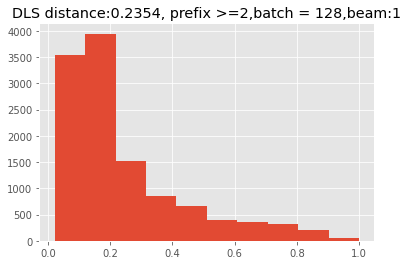

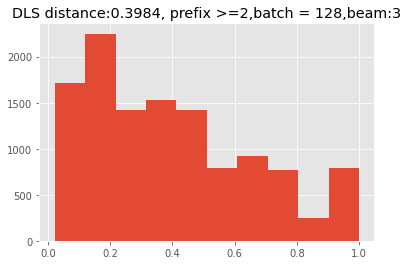

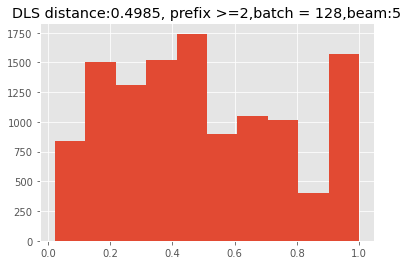

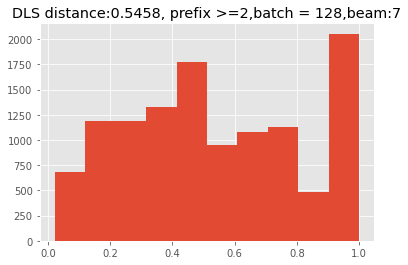

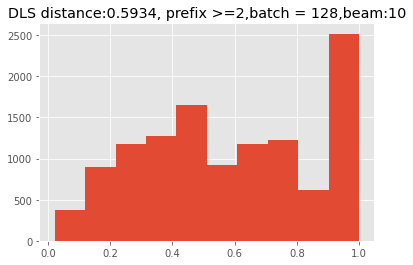

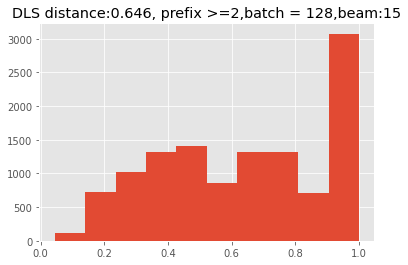

In [ ]:
width=[1,3,5,7,10,15]
#width = range(1,21)
prefix_len_for_suffix_generation =2
for i in width:
  beam_size =i
  suffix_pred_dic, suffix_pred_remain_time_dic, suffix_truth_remain_time_dic, suffix_prefix_dic = suffix_generate6(rnnG_validation, events, test_suffix_loader_partition_list, selected_columns , candidate_num=beam_size)
  distance_values, timError = suffix_similarity3(suffix_pred_dic, suffix_pred_remain_time_dic, suffix_truth_remain_time_dic, suffix_prefix_dic)

  plt.figure()
  plt.hist(distance_values)
  plt.title('DLS distance:'+str(np.round(np.mean(distance_values),4))+ ', prefix >=' + str(prefix_len_for_suffix_generation)+','+"batch = "+str(batch)+','+'beam:'+str(i))
  plt.savefig("/content/drive/My Drive/Deep Learing project/Results/bpi_12_w/"+'bpi_12_w prefix>='+str(prefix_len_for_suffix_generation)+'beam:'+str(i))

In [ ]:
# prefix_len_for_suffix_generation =2
# for i in range(1,beam_size+1):
#   distance_values, timError = suffix_similarity3(suffix_pred_dic, suffix_pred_remain_time_dic, suffix_truth_remain_time_dic, suffix_prefix_dic, beam_size = i)

#   plt.figure()
#   plt.hist(distance_values)
#   plt.title('DLS distance:'+str(np.round(np.mean(distance_values),4))+ ', prefix >=' + str(prefix_len_for_suffix_generation)+','+"batch = "+str(batch)+','+'beam:'+str(i))
#   plt.savefig("/content/drive/My Drive/Deep Learing project/Results/bpi_12_w/"+'bpi_12_w prefix>='+str(prefix_len_for_suffix_generation)+'beam:'+str(i))


In [ ]:
def beam2(candidate, y_pred, events, size=3):
  '''
  candidate: It can be an empty list for the first call, i.e., [], or a list of events with their scores for the next calles, e.g., [ [[2], 2.757077693939209], [[9], 2.7756776809692383],[[3], 3.1773548126220703] ]
  y_pred: The unnormalized output out of the neural net.
  evetns: A list containing the name of events, e.g., [0,1,2,3,4]
  size: The width of beam search

  Return: candidate
  '''
  if(len(candidate)==0):
    temp = torch.sort(F.softmax(y_pred[:,y_pred.size()[1]-1,events],dim=1), descending= True)[1][0][0:size].tolist()
    #temp = torch.sort(F.gumbel_softmax(y_pred[:,y_pred.size()[1]-1,events],dim=1, tau=0.001), descending= True)[1][0][0:size].tolist()
    candidate = [[[e], -F.log_softmax(y_pred[:,y_pred.size()[1]-1,events],dim=1)[0][e].tolist()] for e in temp]
    # [[[0], 0.002113249042700036],
    # [[21], 6.457719656285117],
    # [[22], 7.519231708374177]]
  else:
    temp=[]
    for i in range(len(candidate)):
      if(candidate[i][0][-1]==0):
        continue
      for e in events:
        suffix = candidate[i][0] + [e]
        score = candidate[i][1] - F.log_softmax(y_pred[:,y_pred.size()[1]-1,events],dim=1)[0][e].tolist()
        #candidate[i][1]+= -F.log_softmax(y_pred[:,y_pred.size()[1]-1,events],dim=1)[0][e].tolist()
        temp.append([suffix, score])

    #candidate = sorted(temp,  key = lambda x: x[1])[0:size]
    for c in candidate:
      if (c[0][-1]==0):
        temp.append(c)
    candidate = sorted(temp,  key = lambda x: x[1])[0:size]
    

  return candidate 

#beam2([], y_pred, events,3 )

# a= [[[0], 0.002113249042700036],
#  [[21], 6.457719656285117],
#  [[22], 7.519231708374177],
#  [[23], 16.51466172728471]]

# c,t =beam2(a, y_pred, events, 3)
# a= sorted(t,  key = lambda x: x[1])[0:10]
# print(a)
# c,t =beam2(a, y_pred, events, 3)
#t

In [ ]:
c= beam2([], y_pred, events,3 )
c.append([[0],c[-1][1]])
c

[[[2], 2.757077693939209],
 [[9], 2.7756776809692383],
 [[3], 3.1773548126220703],
 [[0], 3.1773548126220703]]

In [ ]:
import collections
events = list(np.arange(0,len(unique_event)+1))
def class_weights(events):
  # events = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
  #Giving weights to each class which can be used for the optimization (good for imbalacned classes)

  weights=[]
  for tl in train_suffix_loader_partition_list:
    train_suffix_loader = tl

    for mini_batch in iter(train_suffix_loader):
        x = mini_batch[0]; y_truth = mini_batch[1]
        if(x.size()[0]<batch):
          continue
        #weights+=y_truth[:,:,1].view(y_truth.size()[0]).tolist()
        weights+=torch.argmax(y_truth[:,:,events],dim=2).flatten().tolist()
        
    
    #computing the frequency of each class
  weights = collections.Counter(weights)
 

  #print(weights)
  #normalzing the values, giving less weights to frequent classes
  tot = np.sum([weights[key] for key in weights])
  for element in events:
  #for key in weights:
    if element in weights.keys():
      weights[element] = np.round(tot/weights[element],2)
      #If something has not happened in the traning example we assign a minium value since it is not important
    else:
      weights[element] = 1

  #print(weights)
  weights_final = list(collections.OrderedDict(sorted(weights.items())).values())
  print("Class frequencies:", weights)
  print("Class weights:", weights_final)

  return weights_final

weights_final = class_weights(events)
weights_final = torch.tensor(weights_final).float().cuda()

#Manually assigning weights (less weights to the end of sequence)
# weights_final=[]
# for i in range(len(events)):
#   if i == 0:
#     weights_final.append(10)
#   else:
#     weights_final.append(1)

weights_final = weights_final = torch.tensor(weights_final).float().cuda()
print(weights_final)

Class frequencies: Counter({7: 10240.0, 5: 2048.0, 4: 1706.67, 2: 445.22, 1: 445.22, 9: 20.77, 8: 13.35, 6: 2.95, 0: 1.88, 3: 1})
Class weights: [1.88, 445.22, 445.22, 1, 1706.67, 2048.0, 2.95, 10240.0, 13.35, 20.77]
tensor([1.8800e+00, 4.4522e+02, 4.4522e+02, 1.0000e+00, 1.7067e+03, 2.0480e+03,
        2.9500e+00, 1.0240e+04, 1.3350e+01, 2.0770e+01], device='cuda:0')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [ ]:
def one_hot_to_gumble_soft(m):
  '''
  m: a 3 dimensional tensor,e.g., torch.Size([5, 4, 11])
  '''
  #print(torch.argmax(m, dim=2), torch.argmax(m, dim=2).view((m.size()[0], m.size()[1],-1)) )
  m[m==1] =.9
  m[m==0] = 0.1/(m.size()[2]-1)
  m= nn.functional.gumbel_softmax(m,dim=2, tau=0.001)
  return m

# prefix_from_begin.size()
# suffix_to_end.size()
# test_suffix_data = TensorDataset(prefix_from_begin,suffix_to_end)
# test_suffix_loader = DataLoader(dataset=test_suffix_data, batch_size=5, shuffle=False)
